# FINANCIAL CRIME ANALYSIS: CREDIT/DEBIT CARD FRAUD

### Importing Libraries

In [1]:
# Data preprocessing libraries
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates

import os
import sqlite3
import math
import sidetable as stb
from collections import Counter
from pathlib import Path
from tqdm import tqdm

import time
from datetime import datetime
from time import time

# Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

# Config
mpl.rcParams['font.family'] = 'monospace' 
sns.set_theme(style="white", palette=None)
plotly.offline.init_notebook_mode() 
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300



import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

## DATA IMPORT

#### Read Data into a Dataframe

In [3]:
# Reading csv file

df= pd.read_csv("SARStats.csv")
df.index = df.index + 1
df.head()

Year Month       State                  Countym            Industry  \
1  2020 January  California  Contra Costa County, CA  Securities/Futures   
2  2020 January  California  Contra Costa County, CA  Securities/Futures   
3  2020 January  California  Contra Costa County, CA  Securities/Futures   
4  2020 January  California  Contra Costa County, CA  Securities/Futures   
5  2020 January  California  Contra Costa County, CA  Securities/Futures   

            Suspicious Activity Regulator      Product      Instrument Count  
1             Credit/Debit Card       FRB  Credit Card  Funds Transfer     1  
2             Credit/Debit Card       FRB  Credit Card         [Total]     1  
3             Credit/Debit Card   [Total]  Credit Card         [Total]     1  
4  Elder Financial Exploitation       FRB  Credit Card  Funds Transfer     1  
5  Elder Financial Exploitation       FRB  Credit Card         [Total]     1

In [4]:
df.shape

(14850, 9)

In [5]:
df.columns

Index(['Year Month', 'State', 'Countym', 'Industry', 'Suspicious Activity',
       'Regulator', 'Product', 'Instrument', 'Count'],
      dtype='object')

In [6]:
df.isnull().sum()

Year Month             0
State                  0
Countym                0
Industry               0
Suspicious Activity    0
Regulator              0
Product                0
Instrument             0
Count                  0
dtype: int64

##### We can see that there is no column identifying the Type of financial crime that is suspicious in our dataset, we need to create a category for it using the information provided by the data source https://www.fincen.gov/reports/sar-stats

## DATA WRANGLING

### Creating Finacial_Crime_Type Column from Suspicious Activity Column

In [7]:
subcategory_to_category_map = { "Against Financial Institution(s)": "Cyber Events", "Against Financial Institution Customer(s)": "Cyber Events", "Other Cyber Events": "Cyber Events", "Known or Suspected Terrorist/Terrorist Organization": "Terrorist Financing", "Other Terrorist": "Terrorist Financing", "Advance Fee": "Fraud", "ACH": "Fraud", "Check": "Fraud", "Business Loan": "Fraud", "Ponzi Scheme": "Fraud", "Securities Fraud": "Fraud",
                              "Healthcare/Public or Private Health Insurance": "Fraud", "Consumer Loan (see instructions)": "Fraud", "Credit/Debit Card": "Fraud", "Mail": "Fraud", "Mass-Marketing": "Fraud", "Other Fraud (Type)": "Fraud", "Wire": "Fraud", "Changes Spelling or Arrangement of Name": "Identification/Documentation", "Multiple Individuals with Same or Similar Identities": "Identification/Documentation",
                              "Provided Questionable or False Documentation": "Identification/Documentation", "Provided Questionable or False Identification": "Identification/Documentation", "Refused or Avoided Request for Documentation": "Identification/Documentation", "Single Individual with Multiple Identities": "Identification/Documentation", "Other Identification Documentation": "Identification/Documentation",
                              "Exchanges Small Bills for Large Bills or Vice Versa": "Money Laundering", "Funnel Account": "Money Laundering", "Suspicion Concerning the Source of Funds": "Money Laundering", "Suspicious Designation of Beneficiaries, Assignees or Joint Owners": "Money Laundering", "Suspicious EFT/Wire Transfers": "Money Laundering", "Suspicious Exchange of Currencies": "Money Laundering", "Other Money Laundering": "Money Laundering",
                              "Suspicious Receipt of Government Payments/Benefits": "Money Laundering", "Suspicious Use of Multiple Accounts": "Money Laundering", "Suspicious Use of Noncash Monetary Instruments": "Money Laundering", "Suspicious Use of Third-Party Transactors (Straw-Man)": "Money Laundering", "Trade Based Money Laundering/Black Market Peso Exchange": "Money Laundering", "Transaction Out of Pattern for Customer(s)": "Money Laundering",
                              "Application Fraud": "Mortgage Fraud", "Other Mortgage Fraud": "Mortgage Fraud", "Appraisal Fraud": "Mortgage Fraud", "Foreclosure/Short Sale Fraud": "Mortgage Fraud", "Loan Modification Fraud": "Mortgage Fraud", "Origination Fraud": "Mortgage Fraud", "Account Takeover": "Other Suspicious Activities", "Counterfeit Instrument": "Other Suspicious Activities", "Elder Financial Exploitation": "Other Suspicious Activities",
                              "Embezzlement/Theft/Disappearance of Funds": "Other Suspicious Activities", "Forgeries": "Other Suspicious Activities", "Human Trafficking": "Other Suspicious Activities", "Identity Theft": "Other Suspicious Activities", "Little or No Concern for Product Performance Penalites, Fees, or Tax Consequences": "Other Suspicious Activities", "Misuse of Position or Self-Dealing": "Other Suspicious Activities",
                              "Suspicious use of multiple transaction locations": "Other Suspicious Activities", "Transaction with No Apparent Economic, Business, or Lawful Purpose": "Other Suspicious Activities", "Transaction(s) Involving Foreign High Risk Jurisdiction": "Other Suspicious Activities", "Two or More Individuals Working Together": "Other Suspicious Activities", "Unlicensed or Unregistered MSB": "Other Suspicious Activities",
                              "Other Other Suspicious Activities": "Other Suspicious Activities", "Insider Trading": "Securities/Futures/Options", "Market Manipulation": "Securities/Futures/Options", "Misappropriation": "Securities/Futures/Options", "Wash Trading": "Securities/Futures/Options", "Other Securities/Futures/Options": "Securities/Futures/Options", "Transaction(s) Below BSA Recordkeeping Threshold": "Structuring",
                              "Transaction(s) Below CTR Threshold": "Structuring", "Other Structuring": "Structuring"}

df["Financial_Crime_Type"] = df["Suspicious Activity"].map( subcategory_to_category_map )

In [8]:
df.head()

Year Month       State                  Countym            Industry  \
1  2020 January  California  Contra Costa County, CA  Securities/Futures   
2  2020 January  California  Contra Costa County, CA  Securities/Futures   
3  2020 January  California  Contra Costa County, CA  Securities/Futures   
4  2020 January  California  Contra Costa County, CA  Securities/Futures   
5  2020 January  California  Contra Costa County, CA  Securities/Futures   

            Suspicious Activity Regulator      Product      Instrument Count  \
1             Credit/Debit Card       FRB  Credit Card  Funds Transfer     1   
2             Credit/Debit Card       FRB  Credit Card         [Total]     1   
3             Credit/Debit Card   [Total]  Credit Card         [Total]     1   
4  Elder Financial Exploitation       FRB  Credit Card  Funds Transfer     1   
5  Elder Financial Exploitation       FRB  Credit Card         [Total]     1   

          Financial_Crime_Type  
1                        Fraud  
2                        Fraud  
3                        Fraud  
4  Other Suspicious Activities  
5  Other Suspicious Activities

In [9]:
df.isnull().sum()

Year Month                 0
State                      0
Countym                    0
Industry                   0
Suspicious Activity        0
Regulator                  0
Product                    0
Instrument                 0
Count                      0
Financial_Crime_Type    1283
dtype: int64

We observe that the **Financial Crime Type** has **1283** missing values in our dataset, which indicates they are not **Suspicious Activities**. Since we are focusing on analyzing fraud activities then we need to drop the missing values.

In [10]:
df = df.dropna()

In [11]:
df.shape

(13567, 10)

In [12]:
df.isnull().sum()

Year Month              0
State                   0
Countym                 0
Industry                0
Suspicious Activity     0
Regulator               0
Product                 0
Instrument              0
Count                   0
Financial_Crime_Type    0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13567 entries, 1 to 14844
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Year Month            13567 non-null  object
 1   State                 13567 non-null  object
 2   Countym               13567 non-null  object
 3   Industry              13567 non-null  object
 4   Suspicious Activity   13567 non-null  object
 5   Regulator             13567 non-null  object
 6   Product               13567 non-null  object
 7   Instrument            13567 non-null  object
 8   Count                 13567 non-null  object
 9   Financial_Crime_Type  13567 non-null  object
dtypes: object(10)
memory usage: 1.1+ MB


## EXPLORATORY DATA ANALYSIS

In [14]:
df.describe()

Year Month       State              Countym            Industry  \
count       13567       13567                13567               13567   
unique         34          44                  200                   2   
top     2020 July  California  New York County, NY  Securities/Futures   
freq         1716        3101                 1050               12646   

                  Suspicious Activity Regulator      Product Instrument  \
count                           13567     13567        13567      13567   
unique                             64         8            1          9   
top     Suspicious EFT/Wire Transfers       FRB  Credit Card    [Total]   
freq                              990      4189        13567       5986   

        Count         Financial_Crime_Type  
count   13567                        13567  
unique     33                            9  
top         1  Other Suspicious Activities  
freq     8635                         4719

We have **44 states** and **200 county**, Total suspicious activity is **64** and **9 Financial crime type**, **8 Regulators** and **9 instruments**.

In [15]:
df.tail()

Year Month State               Countym                 Industry  \
14840  2022 October  Utah  Salt Lake County, UT  Loan or Finance Company   
14841  2022 October  Utah  Salt Lake County, UT  Loan or Finance Company   
14842  2022 October  Utah  Salt Lake County, UT  Loan or Finance Company   
14843  2022 October  Utah  Salt Lake County, UT  Loan or Finance Company   
14844  2022 October  Utah  Salt Lake County, UT  Loan or Finance Company   

                                     Suspicious Activity Regulator  \
14840                      Suspicious EFT/Wire Transfers      FDIC   
14841                      Suspicious EFT/Wire Transfers   [Total]   
14842  Transaction with No Apparent Economic, Busines...      FDIC   
14843  Transaction with No Apparent Economic, Busines...      FDIC   
14844  Transaction with No Apparent Economic, Busines...   [Total]   

           Product      Instrument Count         Financial_Crime_Type  
14840  Credit Card         [Total]     1             Money Laundering  
14841  Credit Card         [Total]     1             Money Laundering  
14842  Credit Card  Funds Transfer     1  Other Suspicious Activities  
14843  Credit Card         [Total]     1  Other Suspicious Activities  
14844  Credit Card         [Total]     1  Other Suspicious Activities

- Noticing that **[Total]** in the dataset is irrelevant and is the total accumulation of variables in each column, we want to rename them as **unknown**.
- We also want the rename **Count** column to **Filing Count** in other for us to known its the number of times the crime was filed in and also rename **Countym** to **County**.
- It is ideally we convert the **Year Month** column from **object format** to **datetime format** type and separate it individually as **Month** and **Year** column and convert **Count** column to string.

### Replacing [Total] as unknown and renaming Countym and Count columns

In [16]:
df.replace('[Total]','Unkown', inplace = True)
df.rename(columns = {'Countym':'County', 'Count':'Filing_Count', 'Suspicious Activity':'Suspicious_Activity'}, inplace = True)

### Converting Year Month Column To datetime fromat and seperating the column

In [17]:
# convert column to datetime pandas
df['Year Month'] = pd.to_datetime(df['Year Month'])
df['Month_Year'] = df['Year Month'].dt.strftime('%B-%Y')

df[['Month','Year1']] = df.Month_Year.apply(
   lambda x: pd.Series(str(x).split("-")))

df['Day'] = pd.DatetimeIndex(df['Year Month']).day
df['Month_Number'] = pd.DatetimeIndex(df['Year Month']).month
df['Year'] = pd.DatetimeIndex(df['Year Month']).year

In [18]:
# convert column to datetime pandas
df['Year Month'] = pd.to_datetime(df['Year Month'])
df['Month_Year'] = df['Year Month'].dt.strftime('%B-%Y')

df[['Month','Year1']] = df.Month_Year.apply(
   lambda x: pd.Series(str(x).split("-")))

df['Day'] = pd.DatetimeIndex(df['Year Month']).day
df['Month_Number'] = pd.DatetimeIndex(df['Year Month']).month
df['Year'] = pd.DatetimeIndex(df['Year Month']).year


# Droping the columns we dont need
df.drop(['Year Month','Month_Year','Day','Year1'], axis=1, inplace=True)

# conerting Filing_Count column to str
df['Filing_Count'] = df['Filing_Count'].astype(str).astype(int)

In [19]:
df.head()

State                   County            Industry  \
1  California  Contra Costa County, CA  Securities/Futures   
2  California  Contra Costa County, CA  Securities/Futures   
3  California  Contra Costa County, CA  Securities/Futures   
4  California  Contra Costa County, CA  Securities/Futures   
5  California  Contra Costa County, CA  Securities/Futures   

            Suspicious_Activity Regulator      Product      Instrument  \
1             Credit/Debit Card       FRB  Credit Card  Funds Transfer   
2             Credit/Debit Card       FRB  Credit Card          Unkown   
3             Credit/Debit Card    Unkown  Credit Card          Unkown   
4  Elder Financial Exploitation       FRB  Credit Card  Funds Transfer   
5  Elder Financial Exploitation       FRB  Credit Card          Unkown   

   Filing_Count         Financial_Crime_Type    Month  Month_Number  Year  
1             1                        Fraud  January             1  2020  
2             1                        Fraud  January             1  2020  
3             1                        Fraud  January             1  2020  
4             1  Other Suspicious Activities  January             1  2020  
5             1  Other Suspicious Activities  January             1  2020

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13567 entries, 1 to 14844
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   State                 13567 non-null  object
 1   County                13567 non-null  object
 2   Industry              13567 non-null  object
 3   Suspicious_Activity   13567 non-null  object
 4   Regulator             13567 non-null  object
 5   Product               13567 non-null  object
 6   Instrument            13567 non-null  object
 7   Filing_Count          13567 non-null  int32 
 8   Financial_Crime_Type  13567 non-null  object
 9   Month                 13567 non-null  object
 10  Month_Number          13567 non-null  int64 
 11  Year                  13567 non-null  int64 
dtypes: int32(1), int64(2), object(9)
memory usage: 1.3+ MB


We want to create a **S/N** column using the index column for better analysis

### Creating S/N column

In [21]:
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'S/N'})

## Identifying the industry in the dataset for analysis

In [22]:
df["Industry"].value_counts()

Securities/Futures         12646
Loan or Finance Company      921
Name: Industry, dtype: int64

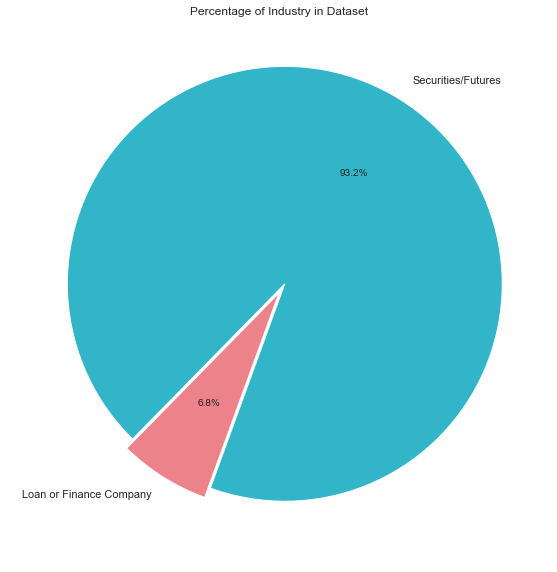

In [23]:
plt.figure(figsize=(20,10))
sizes = df['Industry'].value_counts(sort = True)
colors = ["#32B5C9","#ec838a"] 
explode = (0.05, 0)  # explode 1st slice
labels = 'Securities/Futures','Loan or Finance Company'

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=250,)
plt.title('Percentage of Industry in Dataset')
plt.show()

- The dataset comprises of two industries **Securities/Futures** and **Loan or Finance Company**
- **Securities/Futures** contains **12646** out of **13567** which is **93.2%** 0f the total dastaset, while **Loan or Finance Company** contains only **921** which is just **6.8%** of the total dataset

## VISUALIZATION

### Filed in Financial Crime Type distribution

Financial_Crime_Type
Cyber Events                     513
Fraud                           8853
Identification/Documentation     579
Money Laundering                8676
Mortgage Fraud                   102
Other Suspicious Activities     9861
Securities/Futures/Options       120
Structuring                      663
Terrorist Financing                3
Name: Filing_Count, dtype: int32


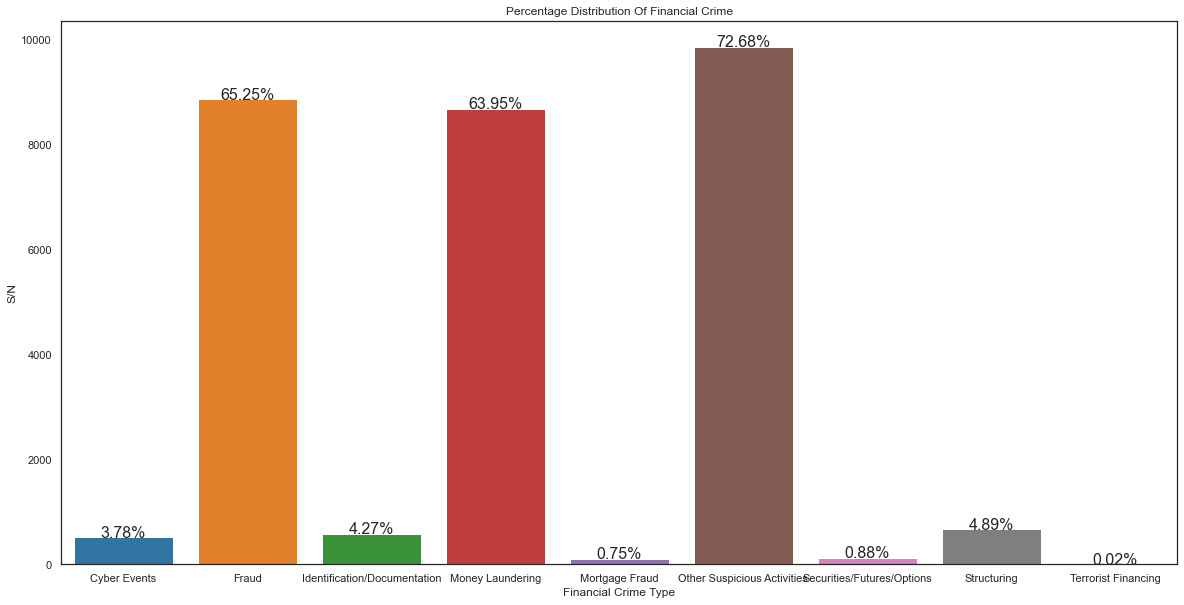

In [24]:
# Visualization for Financial Crime Type Column

Financial_Crime_Type = df.groupby('Financial_Crime_Type')['Filing_Count'].sum()
print(Financial_Crime_Type)

total = len(df)
plt.figure(figsize=(20,10))

plt.rcParams['font.size'] = '16'

ax = sns.barplot(Financial_Crime_Type.index, Financial_Crime_Type.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Percentage Distribution Of Financial Crime")
plt.xlabel("Financial Crime Type")
plt.ylabel("S/N")
plt.show()

- With **72.68%** that is **9,861** Filings **Other Suspicious Activities** has the highest number of **Financial Crime Type** in the dataset that was filed in.
- **8,853** which is **65.25% Fraud** was next
- While **Money Laundering** having **8,676** with **63.95%**, the 3 were the higest number of **Filed Financial Crime Type**

### Filed in Suspicious Activity distribution

In [25]:
df["Filing_Count"].sum()

29370

In [26]:
# Number of times the Suspicious Activity was filed to the agency

df.groupby('Suspicious_Activity')['Filing_Count'].sum()

Suspicious_Activity
ACH                                                        1878
Account Takeover                                           1113
Advance Fee                                                  90
Against Financial Institution Customer(s)                   507
Against Financial Institution(s)                              6
                                                           ... 
Transaction(s) Involving Foreign High Risk Jurisdiction     900
Two or More Individuals Working Together                   1941
Unlicensed or Unregistered MSB                                3
Wash Trading                                                 45
Wire                                                        720
Name: Filing_Count, Length: 64, dtype: int32

### Top Suspicious Activities that has been filed to the agency

Suspicious_Activity
Credit/Debit Card                                   2283
Suspicious EFT/Wire Transfers                       2199
Two or More Individuals Working Together            1941
ACH                                                 1878
Suspicion Concerning the Source of Funds            1647
Identity Theft                                      1605
Suspicious Use of Multiple Accounts                 1584
Other Fraud (Type)                                  1446
Elder Financial Exploitation                        1407
Suspicious use of multiple transaction locations    1197
Name: Filing_Count, dtype: int32


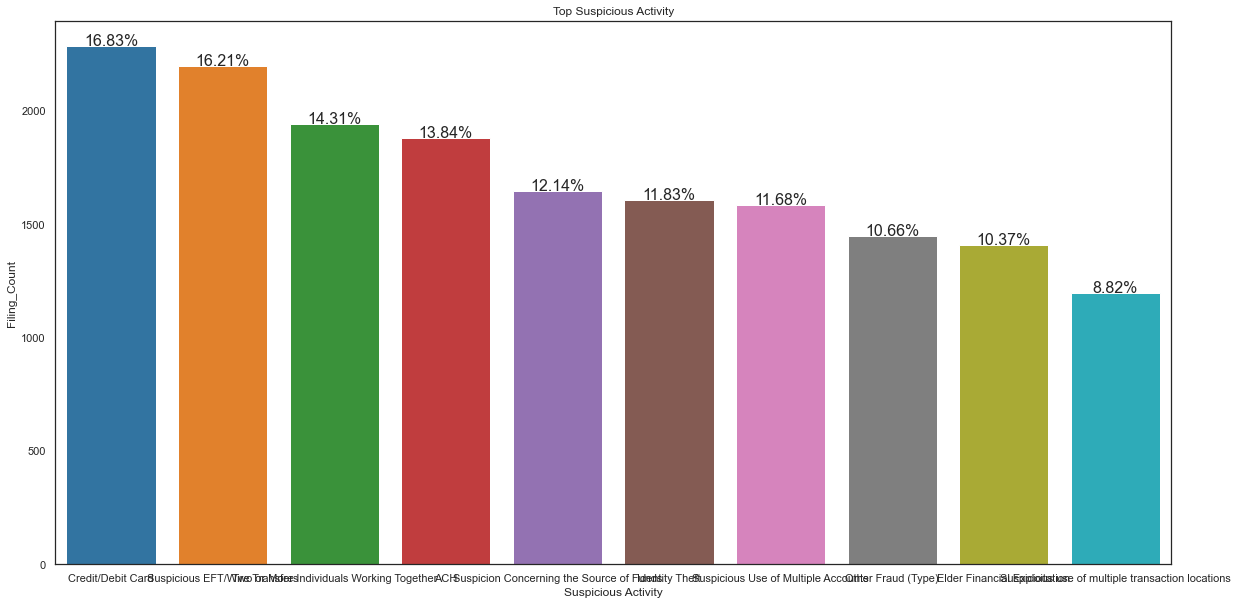

In [27]:
Top_s = df.groupby('Suspicious_Activity')['Filing_Count'].sum().sort_values(ascending=False).head(10)
print(Top_s)

# Plots
plt.figure(figsize=(20,10))
ax = sns.barplot(Top_s.index, Top_s.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Top Suspicious Activity")
plt.xlabel("Suspicious Activity")
plt.ylabel("Filing_Count")
plt.show()

- The total number of **Filed Suspicious Activity** is **29,370**
- **Credit/Debit card Fraud** is the most common **Suspicious Activity** that has been filed in to the agency with **2,283** transactions of **16.83%**

## What are the Top 5 states these crimes mostly occur

In [28]:
df.groupby('State')['Filing_Count'].sum()

State
Alabama                  294
Alaska                   330
Arizona                  543
Arkansas                  15
California              7959
Colorado                 333
Connecticut              195
Delaware                  99
District of Columbia      42
Florida                 2013
Georgia                  990
Idaho                     45
Illinois                 945
Indiana                   39
Iowa                      75
Kansas                   117
Kentucky                  63
Louisiana                 15
Maine                      3
Maryland                 147
Massachusetts            183
Michigan                 171
Minnesota                159
Missouri                4221
Nebraska                 129
Nevada                   837
New Jersey               495
New Mexico               153
New York                3507
North Carolina           888
Ohio                     441
Oklahoma                  42
Oregon                    72
Pennsylvania              96
Puerto R

State
California    7959
Missouri      4221
New York      3507
Florida       2013
Georgia        990
Name: Filing_Count, dtype: int32


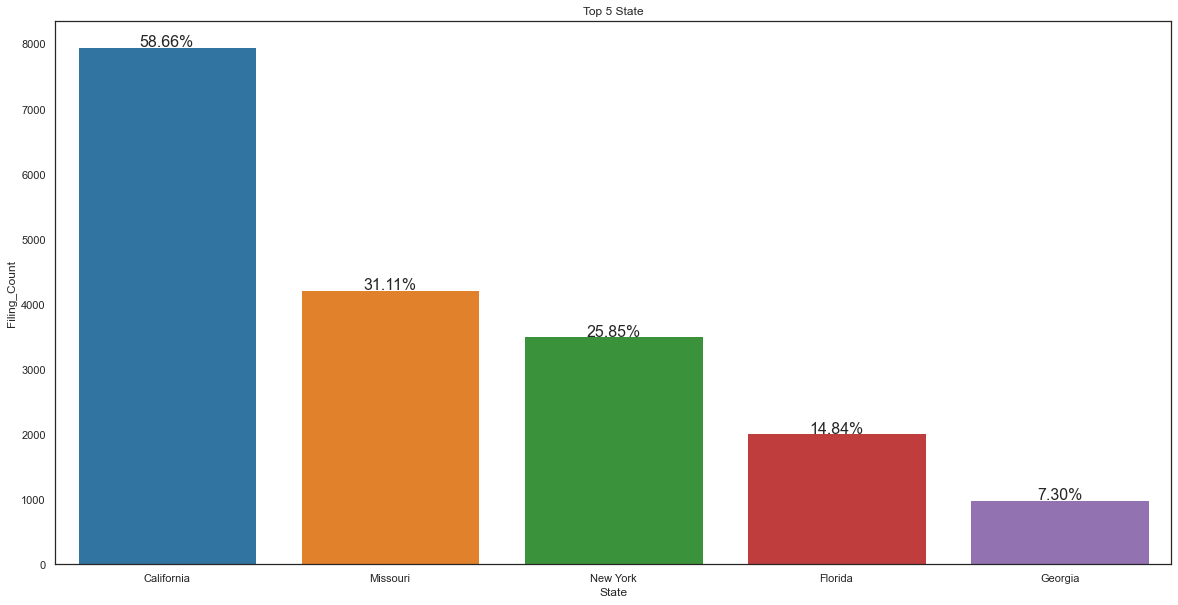

In [29]:
Top_5_st = df.groupby('State')['Filing_Count'].sum().sort_values(ascending=False).head(5)
print(Top_5_st)

# Plots
plt.figure(figsize=(20,10))
ax = sns.barplot(Top_5_st.index, Top_5_st.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Top 5 State")
plt.xlabel("State")
plt.ylabel("Filing_Count")
plt.show()

We can see that in our dataset **Califonia** has the highest report by **State**, **7,959** filed report of financial crimes with **58.66%**

## What are the Top 5 Counties these crimes mostly occur

In [30]:
df.groupby('County')['Filing_Count'].sum()

County
Ada County, ID            15
Adams County, CO         108
Alameda County, CA        24
Albemarle County, VA       6
Alexandria city, VA       42
                        ... 
Williamson County, TN     96
Winnebago County, IL       9
Wood County, WI           48
Yavapai County, AZ        36
York County, SC           48
Name: Filing_Count, Length: 200, dtype: int32

County
St. Louis city, MO          4158
San Francisco County, CA    3345
New York County, NY         2145
Los Angeles County, CA      1350
Orange County, CA            681
Name: Filing_Count, dtype: int32


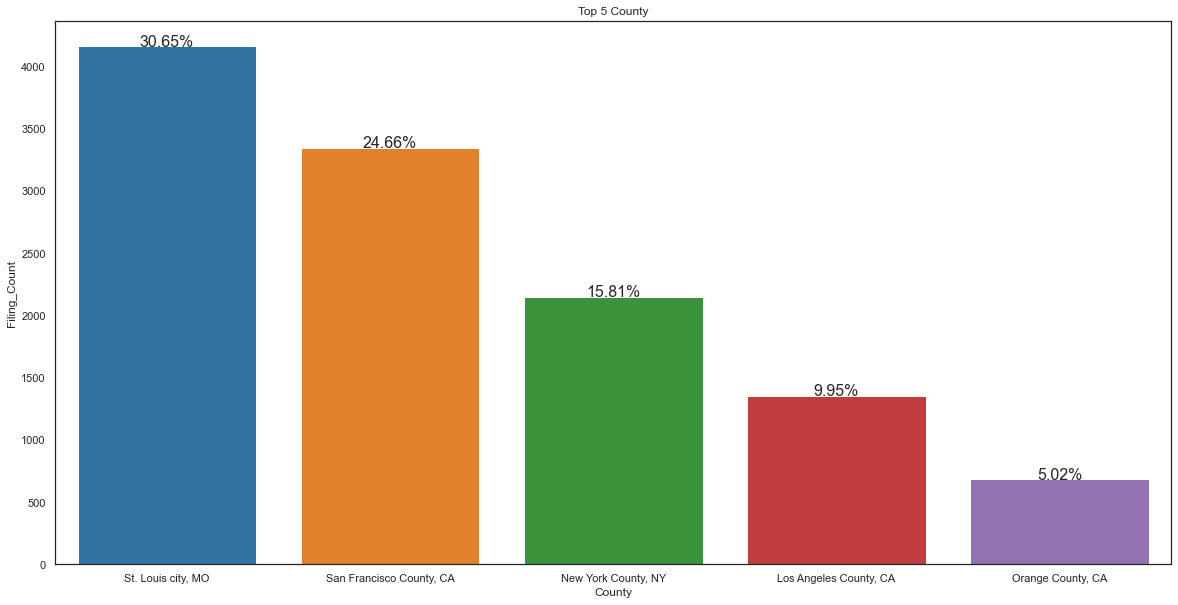

In [31]:
Top_5_c = df.groupby('County')['Filing_Count'].sum().sort_values(ascending=False).head(5)
print(Top_5_c)

# Plots
plt.figure(figsize=(20,10))
ax = sns.barplot(Top_5_c.index, Top_5_c.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Top 5 County")
plt.xlabel("County")
plt.ylabel("Filing_Count")
plt.show()

**St. Louis city** in **Missouri** has **4,158** filed report of financial crimes that is **30.65%** which has the highest report by **County**

## Top Regulatory Institution who filed most reports of Suspicious Activities

FRB               4189
Unkown            2976
OCC               2840
SEC               2803
FDIC               432
Not Applicable     160
NCUA               135
IRS                 32
Name: Regulator, dtype: int64


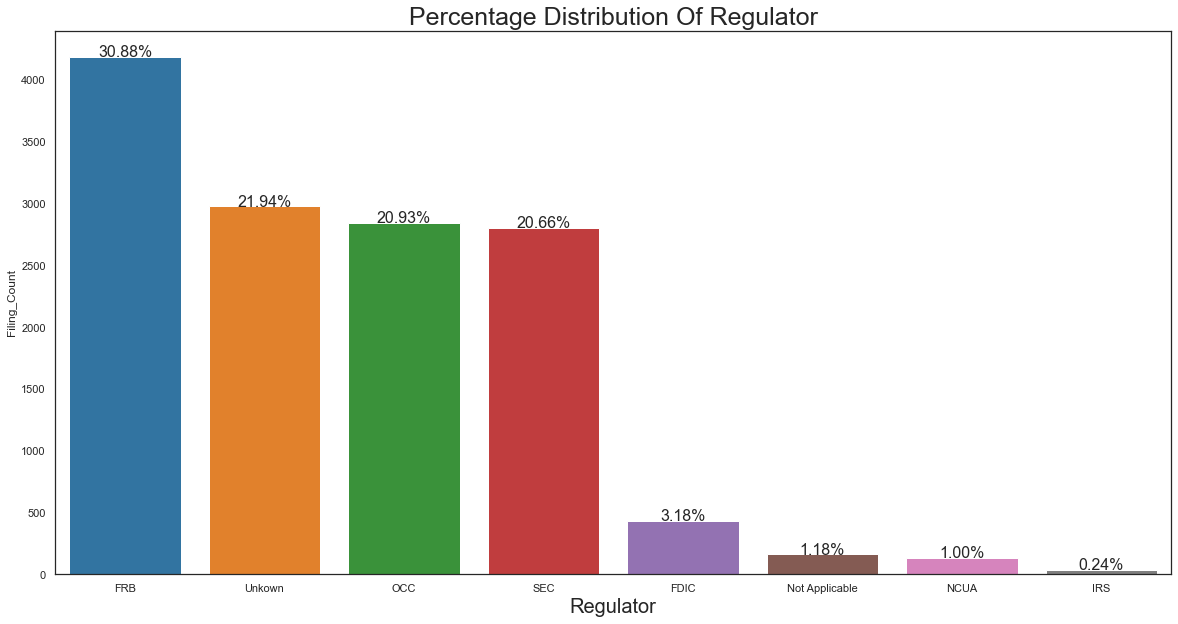

In [32]:
Regulator = df['Regulator'].value_counts()
print(Regulator)

total = len(df)
plt.figure(figsize=(20,10))

plt.rcParams['font.size'] = '16'

ax = sns.barplot(Regulator.index, Regulator.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Percentage Distribution Of Regulator", fontsize=25)
plt.xlabel("Regulator", fontsize=20)
plt.ylabel("Filing_Count")
plt.show()

- From the recorded Regulatory Institution **4,189** with **30.88%**, **FRB** has the highest filed report
- Most of the Regulatory Institution was not recorded about **2,976**, giving us **21.94%** as **Unknown**

## Most used Instrument or Payment Mechanism for the Crime

Unkown                     5986
Funds Transfer             2774
Personal/Business Check    1557
U.S. Currency              1338
Bank/Cashier's Check        923
Government Payment          430
Other                       303
Money Orders                224
Foreign Currency             32
Name: Instrument, dtype: int64


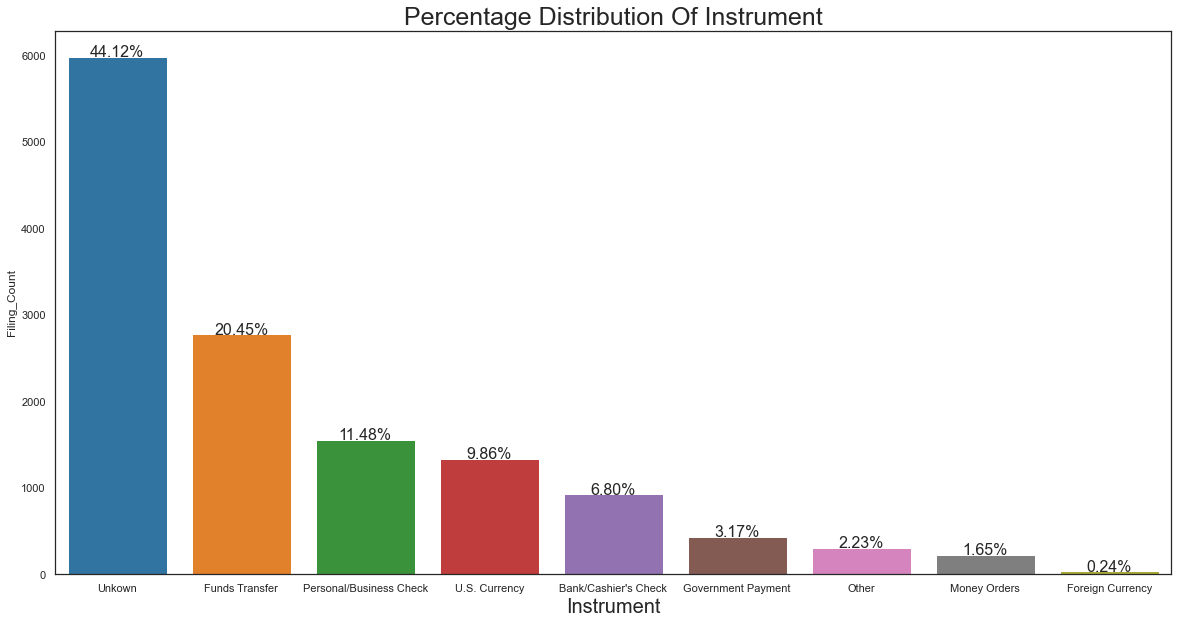

In [33]:
Instrument = df['Instrument'].value_counts()
print(Instrument)

total = len(df)
plt.figure(figsize=(20,10))

plt.rcParams['font.size'] = '16'

ax = sns.barplot(Instrument.index, Instrument.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Percentage Distribution Of Instrument", fontsize=25)
plt.xlabel("Instrument", fontsize=20)
plt.ylabel("Filing_Count")
plt.show()

- Most of the **Payment Mechanism** for the crime is **Unknown** or not recorded with **5,986** giving us a **44.12%**
- The Most used Payment Mechanism is **Funds Transfer** with a **20.45%** having **2,774** reports recorded

## Financial Crime by Year

In [34]:
FinancialCrimeType = pd.get_dummies(df["Financial_Crime_Type"])

In [35]:
df_new = pd.concat([df[["Month", "Year", "Filing_Count", "Financial_Crime_Type", "State"]], FinancialCrimeType], axis=1)

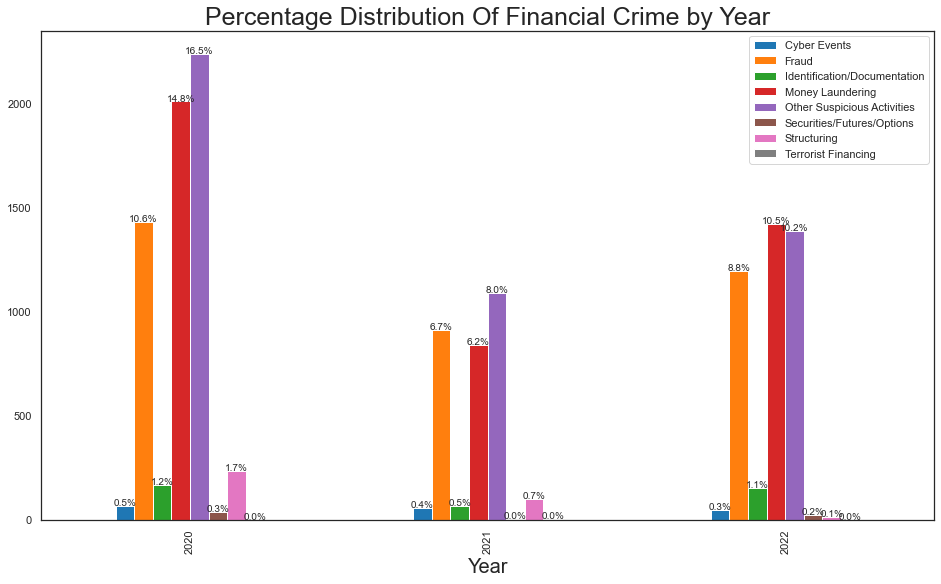

In [36]:
FCY = df_new.groupby(['Year']).agg({'Cyber Events':sum,
                                'Fraud':sum,
                                'Identification/Documentation':sum,
                                'Money Laundering':sum,
                                'Mortgage Fraud':sum,
                                'Other Suspicious Activities':sum,
                                'Securities/Futures/Options':sum,
                                'Structuring':sum,
                                'Terrorist Financing':sum}).reset_index()

FCCY = FCY.plot(x= "Year", y=["Cyber Events", "Fraud", "Identification/Documentation", 'Money Laundering', 'Other Suspicious Activities', 'Securities/Futures/Options', 'Structuring', 'Terrorist Financing'], kind="bar", figsize=(16,9))
for p in FCCY.patches:
    height = p.get_height()
    FCCY.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.1f}%",
            ha="center", fontsize=10)
    
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

plt.title("Percentage Distribution Of Financial Crime by Year", fontsize=25)
plt.xlabel("Year", fontsize=20)
plt.show()

Year **2020** has the highest number of Financial Crime in our dataset with **Other Suspicious Activities, Money Laundering** and **Fraud** being the most committed type 

### Does the Yearly Frequency of the suspected crime correlate with the number of crimes Filed in?

In [37]:
df_side_table = df.stb.freq(['Year'],cum_cols = False)

crime_year = df.groupby('Year').sum()

Crime_by_year = pd.merge(df_side_table, crime_year['Filing_Count'], on=['Year'])
Crime_by_year

Year  count    percent  Filing_Count
0  2020   6194  45.654898         11298
1  2022   4275  31.510282         11802
2  2021   3098  22.834820          6270

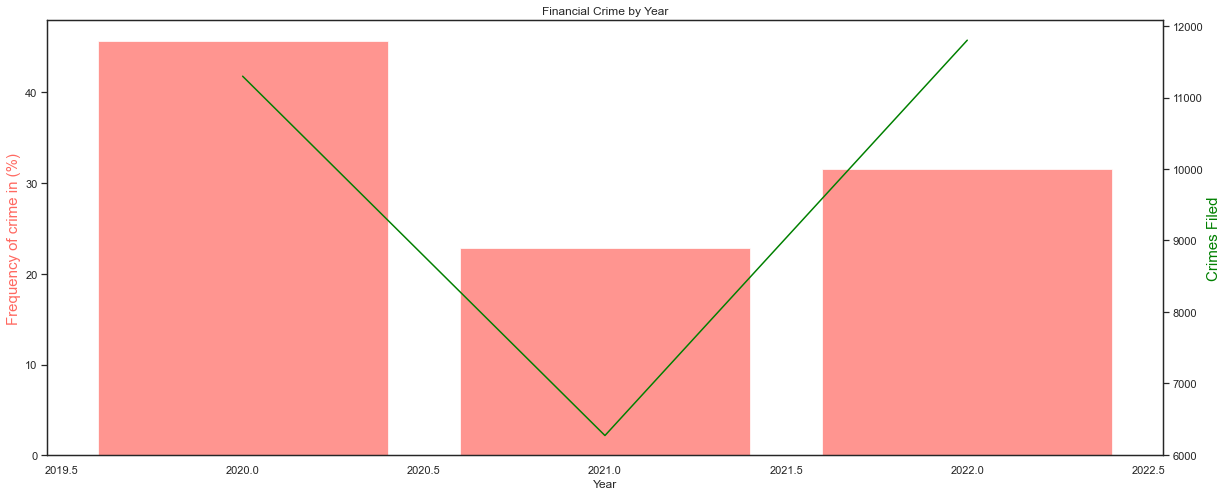

In [38]:
fig, ax1 = plt.subplots(figsize = (20,8))
ax2 = ax1.twinx()


ax1.bar(df_side_table['Year'], df_side_table['percent'], color = '#ff6961', alpha = 0.7)
    
ax1.set_xlabel('Year')
ax1.set_ylabel('Frequency of crime in (%)', color = '#ff6961', size = 15)

ax2.plot(crime_year.index , crime_year['Filing_Count'], color = '#008000')

ax2.set_ylabel('Crimes Filed', size = 15, color = '#008000')

plt.title('Financial Crime by Year')


plt.show()

- From the above table we can see that the number of **Frequent Yearly report** differs from the number of **Crimes Filed** in Yearly
- This is an indication that some **Suspicious Activities were Filed multiple times in one Report**.

## Financial Crime by Month

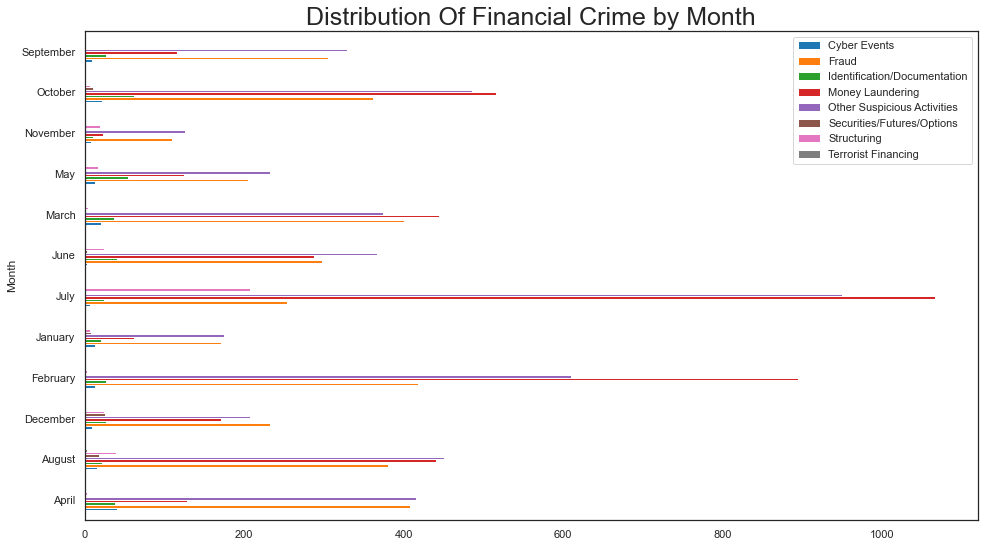

In [39]:
FCY = df_new.groupby(['Month']).agg({'Cyber Events':sum,
                                'Fraud':sum,
                                'Identification/Documentation':sum,
                                'Money Laundering':sum,
                                'Mortgage Fraud':sum,
                                'Other Suspicious Activities':sum,
                                'Securities/Futures/Options':sum,
                                'Structuring':sum,
                                'Terrorist Financing':sum}).reset_index()

FCCY = FCY.plot(x= "Month", y=["Cyber Events", "Fraud", "Identification/Documentation", 'Money Laundering', 'Other Suspicious Activities', 'Securities/Futures/Options', 'Structuring', 'Terrorist Financing'], kind="barh", figsize=(16,9))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

plt.title("Distribution Of Financial Crime by Month", fontsize=25)
plt.show()

The Month of **July** has the highest number of report in our dataset

### What Months of the Year did the Crime usually happen by Financial Crime type

In [40]:
df.groupby('Financial_Crime_Type')['Month_Number'].mean()

Financial_Crime_Type
Cyber Events                    5.828402
Fraud                           6.160169
Identification/Documentation    6.387013
Money Laundering                5.976603
Mortgage Fraud                  7.806452
Other Suspicious Activities     6.243484
Securities/Futures/Options      8.906250
Structuring                     7.344729
Terrorist Financing             8.000000
Name: Month_Number, dtype: float64

- This is an indication that the frequent number of reports of crime are within the month of **MAY** to **AUGUST**
- the month with the most frequent number of multiple crime is **JUNE** having **Fraud, Identification/Documentation** and **Other Suspicious Activities** crime reports in that same month

### Does the Frequent number of the suspected crime correlate with the number of crimes Filed in Monthly?

In [41]:
Frq = df.stb.freq(['Month_Number'],cum_cols = False)

crime_Month_Number = df.groupby('Month_Number').sum()

Crime_by_Month = pd.merge(crime_Month_Number['Filing_Count'], Frq, on=['Month_Number'])
Crime_by_Month['Month'] = ['January','February','March','April','May','June','July','August', 'September','October','November','December']
Crime_by_Month

Month_Number  Filing_Count  count    percent      Month
0              1           807    459   3.383209    January
1              2          4026   1966  14.491044   February
2              3          2571   1279   9.427287      March
3              4          1656   1032   7.606693      April
4              5          1632    642   4.732070        May
5              6          2259   1020   7.518243       June
6              7          5838   2508  18.486032       July
7              8          3195   1421  10.473944     August
8              9          2358    785   5.786099  September
9             10          3273   1464  10.790890    October
10            11           492    293   2.159652   November
11            12          1263    698   5.144837   December

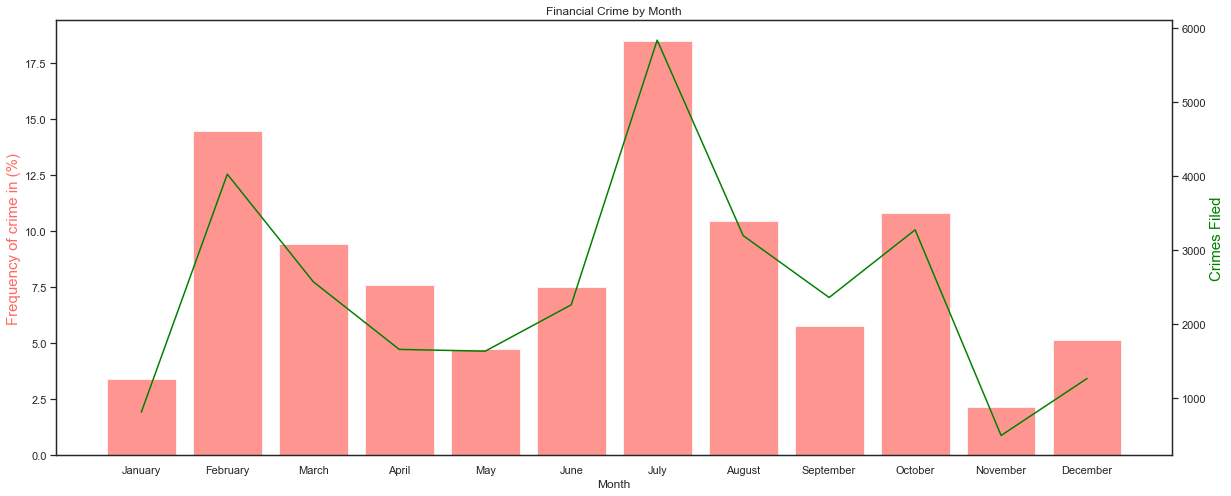

In [42]:
fig, ax1 = plt.subplots(figsize = (20,8))
ax2 = ax1.twinx()


ax1.bar(Crime_by_Month['Month'], Crime_by_Month['percent'], color = '#ff6961', alpha = 0.7)
    
ax1.set_xlabel('Month')
ax1.set_ylabel('Frequency of crime in (%)', color = '#ff6961', size = 15)
ax2.plot(Crime_by_Month.index , Crime_by_Month['Filing_Count'], color = '#008000')

ax2.set_ylabel('Crimes Filed', size = 15, color = '#008000')

plt.title('Financial Crime by Month')


plt.show()

- From the above table and chart we can see that despite **MAY** to **AUGUST** being the most frequent month reported, **JULY, FEBRUARY, OCTOBER, AUGUST** and **MARCH** has the highest **Filed in report** with **18.5%, 14.5%, 10.8%, 10.5%** and **9.4%** respectively.
- This tells us that the frequency of the report of crime by **Month** does not indicate the number of Suspicious crime reports committed

# LET US LOOK AT THE TOP 5 FINANCIAL CRIMES REPORTED

In [43]:
Financial_Crime = df.groupby('Financial_Crime_Type')['Filing_Count'].sum().sort_values(ascending=False).head(5)
Financial_Crime

Financial_Crime_Type
Other Suspicious Activities     9861
Fraud                           8853
Money Laundering                8676
Structuring                      663
Identification/Documentation     579
Name: Filing_Count, dtype: int32

In [44]:
Suspiciuos_crime = df.groupby('Suspicious_Activity')['Filing_Count'].sum().sort_values(ascending=False).head(10)
Suspiciuos_crime

Suspicious_Activity
Credit/Debit Card                                   2283
Suspicious EFT/Wire Transfers                       2199
Two or More Individuals Working Together            1941
ACH                                                 1878
Suspicion Concerning the Source of Funds            1647
Identity Theft                                      1605
Suspicious Use of Multiple Accounts                 1584
Other Fraud (Type)                                  1446
Elder Financial Exploitation                        1407
Suspicious use of multiple transaction locations    1197
Name: Filing_Count, dtype: int32

## CREDIT/DEBIT CARD FRAUD

In [45]:
Credit_card_data = df[df.Suspicious_Activity=='Credit/Debit Card']
Credit_card_data.head()

S/N       State                   County            Industry  \
0     1  California  Contra Costa County, CA  Securities/Futures   
1     2  California  Contra Costa County, CA  Securities/Futures   
2     3  California  Contra Costa County, CA  Securities/Futures   
44   53  California    Stanislaus County, CA  Securities/Futures   
45   54  California    Stanislaus County, CA  Securities/Futures   

   Suspicious_Activity Regulator      Product            Instrument  \
0    Credit/Debit Card       FRB  Credit Card        Funds Transfer   
1    Credit/Debit Card       FRB  Credit Card                Unkown   
2    Credit/Debit Card    Unkown  Credit Card                Unkown   
44   Credit/Debit Card       SEC  Credit Card  Bank/Cashier's Check   
45   Credit/Debit Card       SEC  Credit Card        Funds Transfer   

    Filing_Count Financial_Crime_Type    Month  Month_Number  Year  
0              1                Fraud  January             1  2020  
1              1                Fraud  January             1  2020  
2              1                Fraud  January             1  2020  
44             1                Fraud  January             1  2020  
45             1                Fraud  January             1  2020

In [46]:
CD_data = Credit_card_data.copy()
CD_data.drop(['S/N','Month_Number','Year','Filing_Count'], axis=1, inplace=True)


CD_data.describe()

State              County            Industry  \
count          848                 848                 848   
unique          37                 102                   2   
top     California  St. Louis city, MO  Securities/Futures   
freq           193                 106                 770   

       Suspicious_Activity Regulator      Product Instrument  \
count                  848       848          848        848   
unique                   1         7            1          8   
top      Credit/Debit Card       SEC  Credit Card     Unkown   
freq                   848       250          848        459   

       Financial_Crime_Type  Month  
count                   848    848  
unique                    1     12  
top                   Fraud  April  
freq                    848    113

#### CREDIT/DEBIT CARD FRAUD TOP 5 STATE

State
California    822
Missouri      588
New York      198
Florida       150
Georgia        45
Name: Filing_Count, dtype: int32


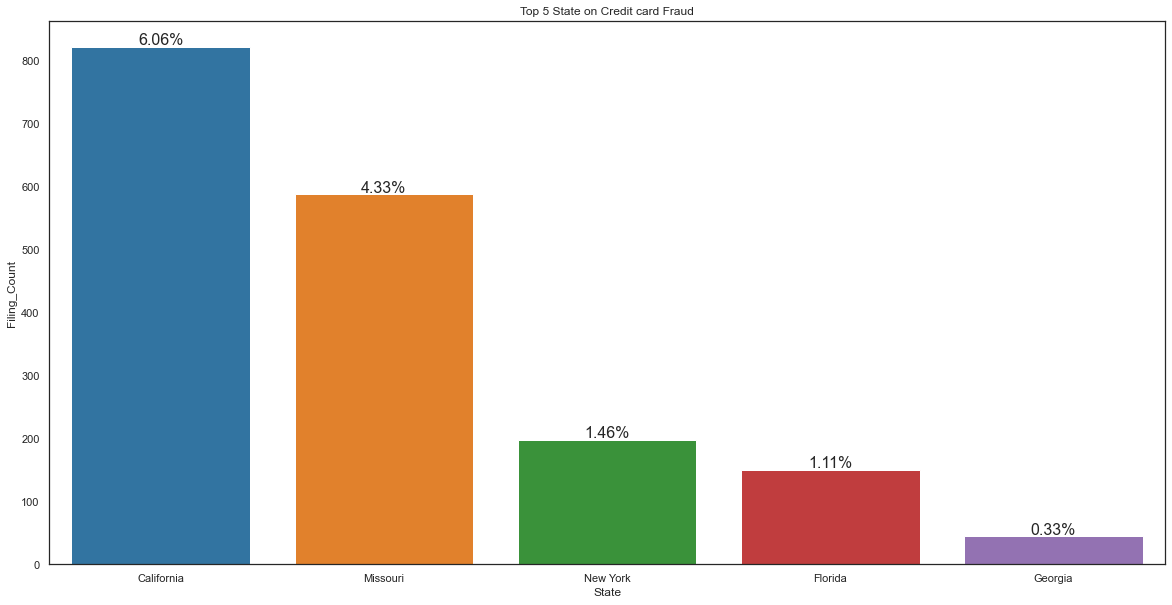

In [47]:
TC = Credit_card_data.groupby('State')['Filing_Count'].sum().sort_values(ascending=False).head(5)
print(TC)

# Plots
plt.figure(figsize=(20,10))
ax = sns.barplot(TC.index, TC.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Top 5 State on Credit card Fraud")
plt.xlabel("State")
plt.ylabel("Filing_Count")
plt.show()

#### CREDIT/DEBIT CARD FRAUD TOP 5 COUNTY

County
St. Louis city, MO          579
San Francisco County, CA    552
New York County, NY         168
Seminole County, FL          84
San Mateo County, CA         78
Name: Filing_Count, dtype: int32


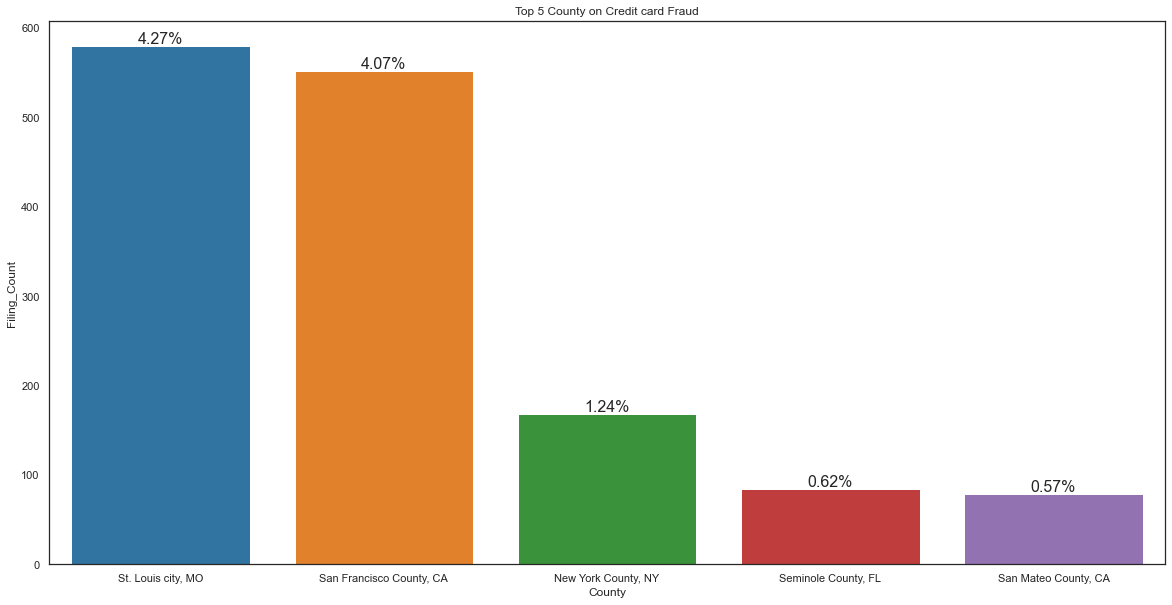

In [48]:
TCC = Credit_card_data.groupby('County')['Filing_Count'].sum().sort_values(ascending=False).head(5)
print(TCC)

# Plots
plt.figure(figsize=(20,10))
ax = sns.barplot(TCC.index, TCC.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Top 5 County on Credit card Fraud")
plt.xlabel("County")
plt.ylabel("Filing_Count")
plt.show()

### Common Instrument or Payment Mechanism used for Credit/Debit card fraud

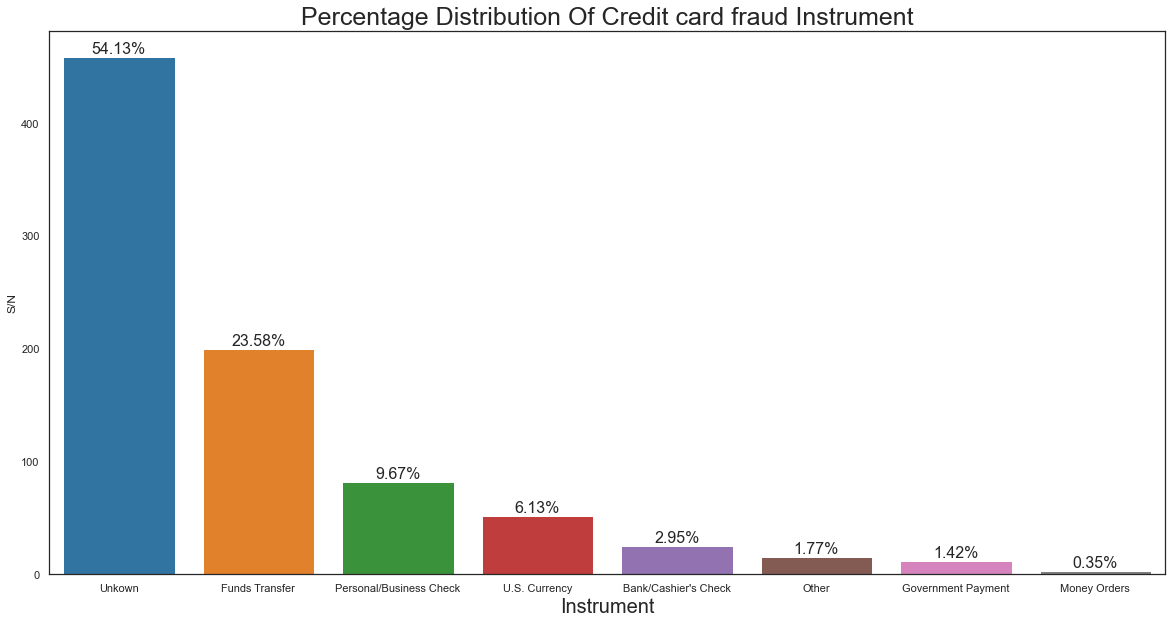

In [49]:
CD_Instrument = Credit_card_data['Instrument'].value_counts()

total = len(Credit_card_data)
plt.figure(figsize=(20,10))

plt.rcParams['font.size'] = '16'

ax = sns.barplot(CD_Instrument.index, CD_Instrument.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Percentage Distribution Of Credit card fraud Instrument", fontsize=25)
plt.xlabel("Instrument", fontsize=20)
plt.ylabel("S/N")
plt.show()

### What Month of the Year the does Credit/Debit card fraud usually happen

In [50]:
Credit_table = Credit_card_data.stb.freq(['Year'],cum_cols = False)
Credit_table

Year  count    percent
0  2020    377  44.457547
1  2022    251  29.599057
2  2021    220  25.943396

### Does the number of the Credit/Debit Card Fraud correlate with the number of crimes Filed in Monthly?

In [51]:
FrqC = Credit_card_data.stb.freq(['Month_Number'],cum_cols = False)

C_crime_Month_Number = Credit_card_data.groupby('Month_Number').sum()

C_Crime_by_Month = pd.merge(C_crime_Month_Number['Filing_Count'], FrqC, on=['Month_Number'])
C_Crime_by_Month['Month'] = ['January','February','March','April','May','June','July','August', 'September','October','November','December']
C_Crime_by_Month

Month_Number  Filing_Count  count    percent      Month
0              1           111     50   5.896226    January
1              2           213    102  12.028302   February
2              3           135     73   8.608491      March
3              4           189    113  13.325472      April
4              5           171     56   6.603774        May
5              6           165     62   7.311321       June
6              7           348     72   8.490566       July
7              8           336     98  11.556604     August
8              9           306     88  10.377358  September
9             10           174     60   7.075472    October
10            11            63     30   3.537736   November
11            12            72     44   5.188679   December

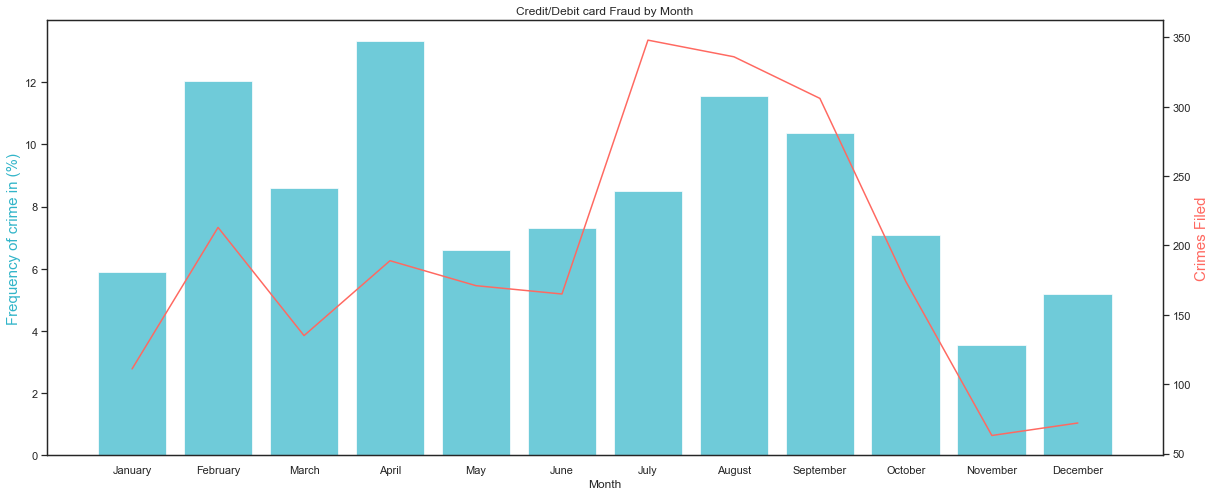

In [52]:
fig, ax1 = plt.subplots(figsize = (20,8))
ax2 = ax1.twinx()


ax1.bar(C_Crime_by_Month['Month'], C_Crime_by_Month['percent'], color = '#32B5C9', alpha = 0.7)
    
ax1.set_xlabel('Month')
ax1.set_ylabel('Frequency of crime in (%)', color = '#32B5C9', size = 15)
ax2.plot(C_Crime_by_Month.index , C_Crime_by_Month['Filing_Count'], color = '#ff6961')

ax2.set_ylabel('Crimes Filed', size = 15, color = '#ff6961')

plt.title('Credit/Debit card Fraud by Month')


plt.show()

## MONEY LAUNDERING

In [53]:
Money_L_data = df[df.Financial_Crime_Type=='Money Laundering']
Money_L_data.head()

S/N       State                  County            Industry  \
24   31  California  Los Angeles County, CA  Securities/Futures   
25   32  California  Los Angeles County, CA  Securities/Futures   
26   33  California  Los Angeles County, CA  Securities/Futures   
27   34  California  Los Angeles County, CA  Securities/Futures   
28   35  California  Los Angeles County, CA  Securities/Futures   

                         Suspicious_Activity Regulator      Product  \
24  Suspicion Concerning the Source of Funds       OCC  Credit Card   
25  Suspicion Concerning the Source of Funds       OCC  Credit Card   
26  Suspicion Concerning the Source of Funds       OCC  Credit Card   
27  Suspicion Concerning the Source of Funds    Unkown  Credit Card   
28             Suspicious EFT/Wire Transfers       OCC  Credit Card   

                 Instrument  Filing_Count Financial_Crime_Type    Month  \
24           Funds Transfer             1     Money Laundering  January   
25  Personal/Business Check             1     Money Laundering  January   
26                   Unkown             2     Money Laundering  January   
27                   Unkown             2     Money Laundering  January   
28           Funds Transfer             1     Money Laundering  January   

    Month_Number  Year  
24             1  2020  
25             1  2020  
26             1  2020  
27             1  2020  
28             1  2020

In [54]:
ML_data = Money_L_data.copy()
ML_data.drop(['S/N','Month_Number','Year','Filing_Count'], axis=1, inplace=True)


ML_data.describe()

State               County            Industry  \
count         4274                 4274                4274   
unique          36                  125                   2   
top     California  New York County, NY  Securities/Futures   
freq          1053                  268                3985   

                  Suspicious_Activity Regulator      Product Instrument  \
count                            4274      4274         4274       4274   
unique                             13         8            1          9   
top     Suspicious EFT/Wire Transfers       FRB  Credit Card     Unkown   
freq                              990      1495         4274       1623   

       Financial_Crime_Type Month  
count                  4274  4274  
unique                    1    12  
top        Money Laundering  July  
freq                   4274  1067

#### MONEY LAUNDERING CRIME TOP 5 STATE

State
California    2412
New York      1122
Florida        711
Illinois       456
Utah           450
Name: Filing_Count, dtype: int32


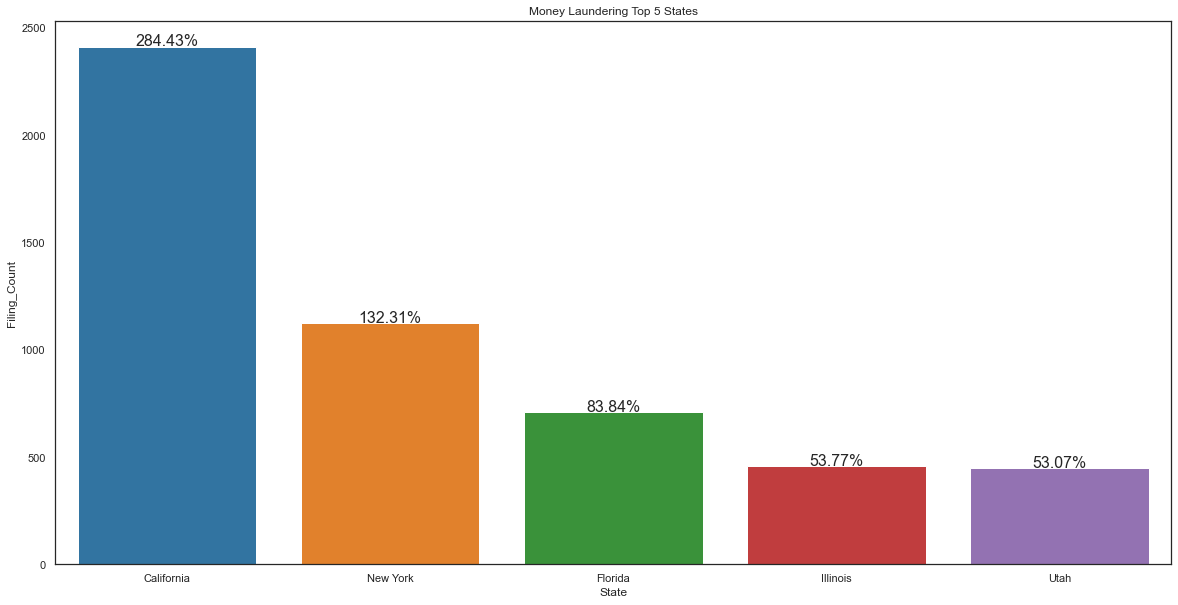

In [55]:
ML = Money_L_data.groupby('State')['Filing_Count'].sum().sort_values(ascending=False).head(5)
print(ML)

# Plots
plt.figure(figsize=(20,10))
ax = sns.barplot(ML.index, ML.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Money Laundering Top 5 States")
plt.xlabel("State")
plt.ylabel("Filing_Count")
plt.show()

#### MONEY LAUNDERING CRIME TOP 5 COUNTY

County
San Francisco County, CA    828
New York County, NY         576
Los Angeles County, CA      495
Clark County, NV            273
Salt Lake County, UT        270
Name: Filing_Count, dtype: int32


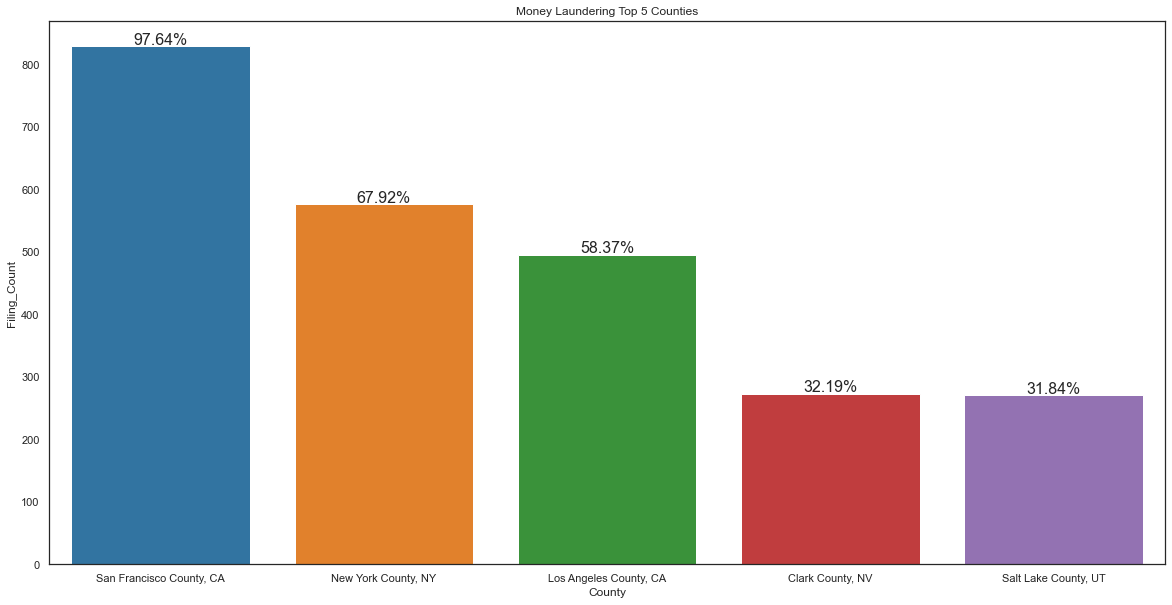

In [56]:
MLC = Money_L_data.groupby('County')['Filing_Count'].sum().sort_values(ascending=False).head(5)
print(MLC)

# Plots
plt.figure(figsize=(20,10))
ax = sns.barplot(MLC.index, MLC.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Money Laundering Top 5 Counties")
plt.xlabel("County")
plt.ylabel("Filing_Count")
plt.show()

### TOP 5 SUSPICIOUS ACTIVITIES CARRIED OUT BY MONEY LAUNDERING

Suspicious_Activity
Suspicious EFT/Wire Transfers                     2199
Suspicion Concerning the Source of Funds          1647
Suspicious Use of Multiple Accounts               1584
Suspicious Use of Noncash Monetary Instruments     909
Transaction Out of Pattern for Customer(s)         831
Name: Filing_Count, dtype: int32


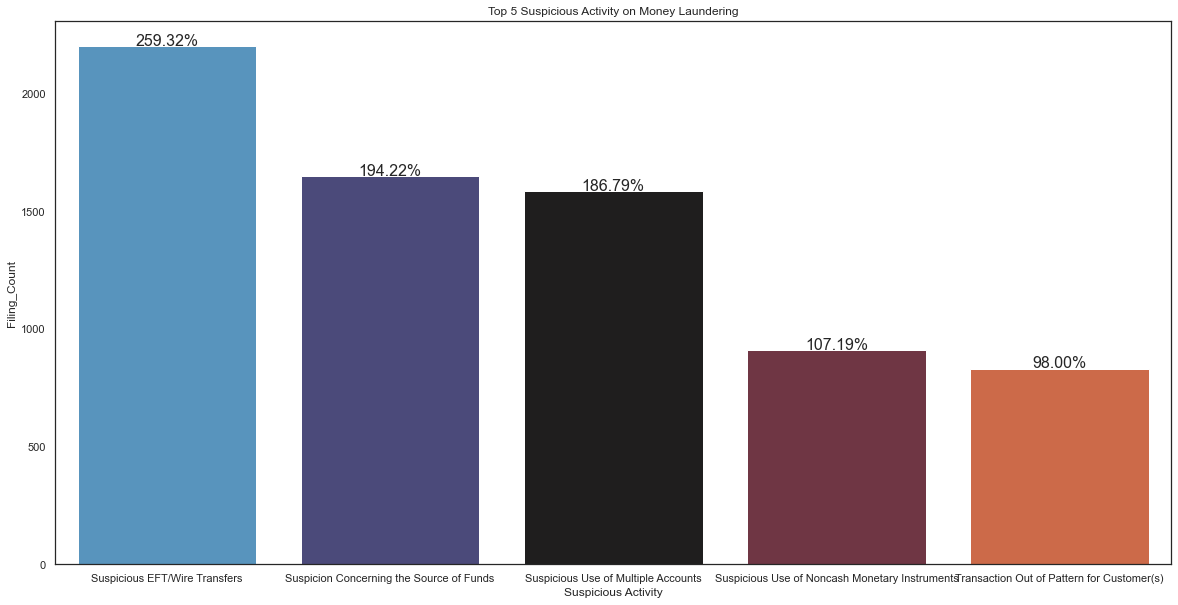

In [57]:
Top_s_ML = Money_L_data.groupby('Suspicious_Activity')['Filing_Count'].sum().sort_values(ascending=False).head(5)
print(Top_s_ML)

# Plots
plt.figure(figsize=(20,10))
ax = sns.barplot(Top_s_ML.index, Top_s_ML.values, palette = 'icefire')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Top 5 Suspicious Activity on Money Laundering")
plt.xlabel("Suspicious Activity")
plt.ylabel("Filing_Count")
plt.show()

### Instrument used for Money Laundering

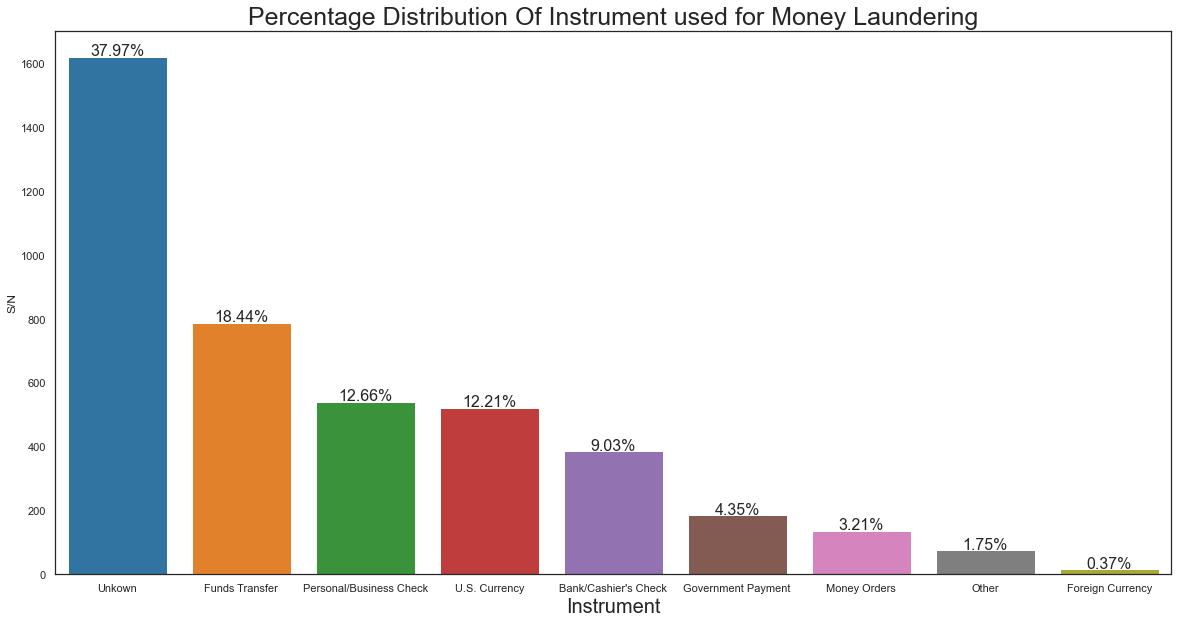

In [58]:
ML_Instrument = Money_L_data['Instrument'].value_counts()

total = len(Money_L_data)
plt.figure(figsize=(20,10))

plt.rcParams['font.size'] = '16'

ax = sns.barplot(ML_Instrument.index, ML_Instrument.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Percentage Distribution Of Instrument used for Money Laundering", fontsize=25)
plt.xlabel("Instrument", fontsize=20)
plt.ylabel("S/N")
plt.show()

### What Month of the Year the does crime on Money Laundery usually happen

In [59]:
ML_table = Money_L_data.stb.freq(['Year'],cum_cols = False)
ML_table

Year  count    percent
0  2020   2011  47.051942
1  2022   1421  33.247543
2  2021    842  19.700515

In [60]:
FrqML = Money_L_data.stb.freq(['Month_Number'],cum_cols = False)

ML_crime_Month_Number = Money_L_data.groupby('Month_Number').sum()

ML_Crime_by_Month = pd.merge(ML_crime_Month_Number['Filing_Count'], FrqML, on=['Month_Number'])
ML_Crime_by_Month['Month'] = ['January','February','March','April','May','June','July','August', 'September','October','November','December']
ML_Crime_by_Month

Month_Number  Filing_Count  count    percent      Month
0              1            90     62   1.450632    January
1              2          1812    895  20.940571   February
2              3           909    444  10.388395      March
3              4           204    128   2.994853      April
4              5           249    124   2.901263        May
5              6           672    287   6.715021       June
6              7          2124   1067  24.964904       July
7              8           921    441  10.318203     August
8              9           267    116   2.714085  September
9             10          1062    516  12.073000    October
10            11            39     23   0.538138   November
11            12           327    171   4.000936   December

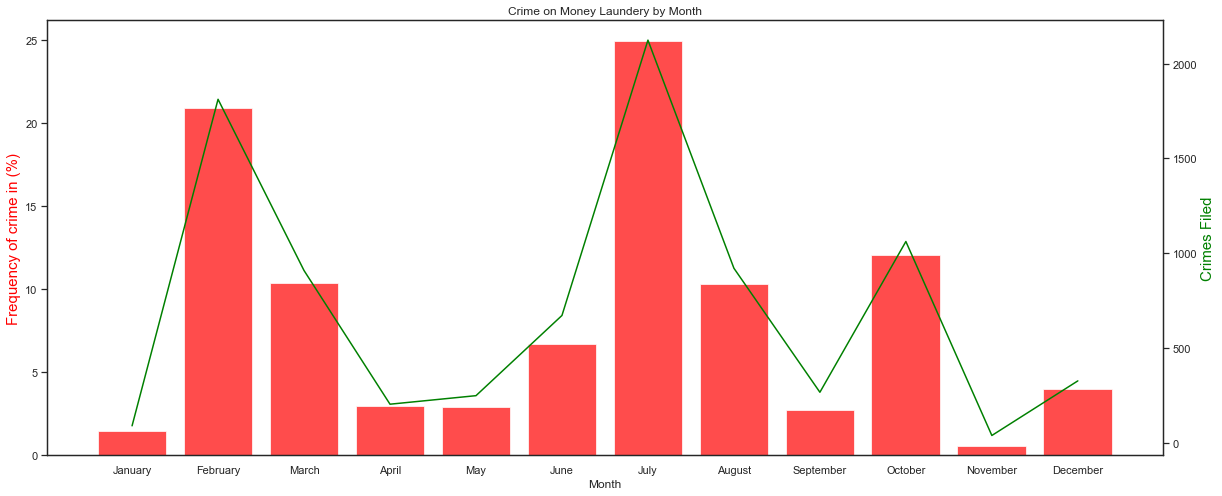

In [61]:
fig, ax1 = plt.subplots(figsize = (20,8))
ax2 = ax1.twinx()


ax1.bar(ML_Crime_by_Month['Month'], ML_Crime_by_Month['percent'], color = 'r', alpha = 0.7)
    
ax1.set_xlabel('Month')
ax1.set_ylabel('Frequency of crime in (%)', color = 'r', size = 15)
ax2.plot(ML_Crime_by_Month.index , ML_Crime_by_Month['Filing_Count'], color = '#008000')

ax2.set_ylabel('Crimes Filed', size = 15, color = '#008000')

plt.title('Crime on Money Laundery by Month')


plt.show()

## AUTOMATED CLEARING HOUSE (ACH) FRAUD

#### WHAT IS ACH FRAUD

ACH fraud is unauthorized Automated Clearing House (ACH) transactions or the fraudulent transfer of funds made through the electronic payments network known as the ACH Network in the United States. ACH fraud typically targets a specific bank account and takes advantage of the time delay that occurs in ACH processing.
https://www.silamoney.com/ach/understanding-the-basics-of-ach-fraud

In [62]:
ACH_data = df[df.Suspicious_Activity=='ACH']
ACH_data.head()

S/N     State               County            Industry  \
119    142  Missouri   St. Louis city, MO  Securities/Futures   
120    143  Missouri   St. Louis city, MO  Securities/Futures   
121    144  Missouri   St. Louis city, MO  Securities/Futures   
1237  1346  New York  New York County, NY  Securities/Futures   
1238  1347  New York  New York County, NY  Securities/Futures   

     Suspicious_Activity Regulator      Product      Instrument  Filing_Count  \
119                  ACH       FRB  Credit Card  Funds Transfer             2   
120                  ACH       FRB  Credit Card          Unkown             2   
121                  ACH    Unkown  Credit Card          Unkown             2   
1237                 ACH       SEC  Credit Card  Funds Transfer             2   
1238                 ACH       SEC  Credit Card           Other             1   

     Financial_Crime_Type     Month  Month_Number  Year  
119                 Fraud   January             1  2020  
120                 Fraud   January             1  2020  
121                 Fraud   January             1  2020  
1237                Fraud  February             2  2020  
1238                Fraud  February             2  2020

In [63]:
Ach_d = ACH_data.copy()
Ach_d.drop(['S/N','Month_Number','Year','Filing_Count'], axis=1, inplace=True)


Ach_d.describe()

State              County            Industry  \
count          659                 659                 659   
unique          24                  65                   2   
top     California  St. Louis city, MO  Securities/Futures   
freq           206                  78                 598   

       Suspicious_Activity Regulator      Product Instrument  \
count                  659       659          659        659   
unique                   1         6            1          8   
top                    ACH       SEC  Credit Card     Unkown   
freq                   659       204          659        328   

       Financial_Crime_Type    Month  
count                   659      659  
unique                    1       12  
top                   Fraud  October  
freq                    659       83

#### ACH FRAUD TOP 5 STATE

State
California    870
Missouri      375
New York      174
Florida       132
Texas          39
Name: Filing_Count, dtype: int32


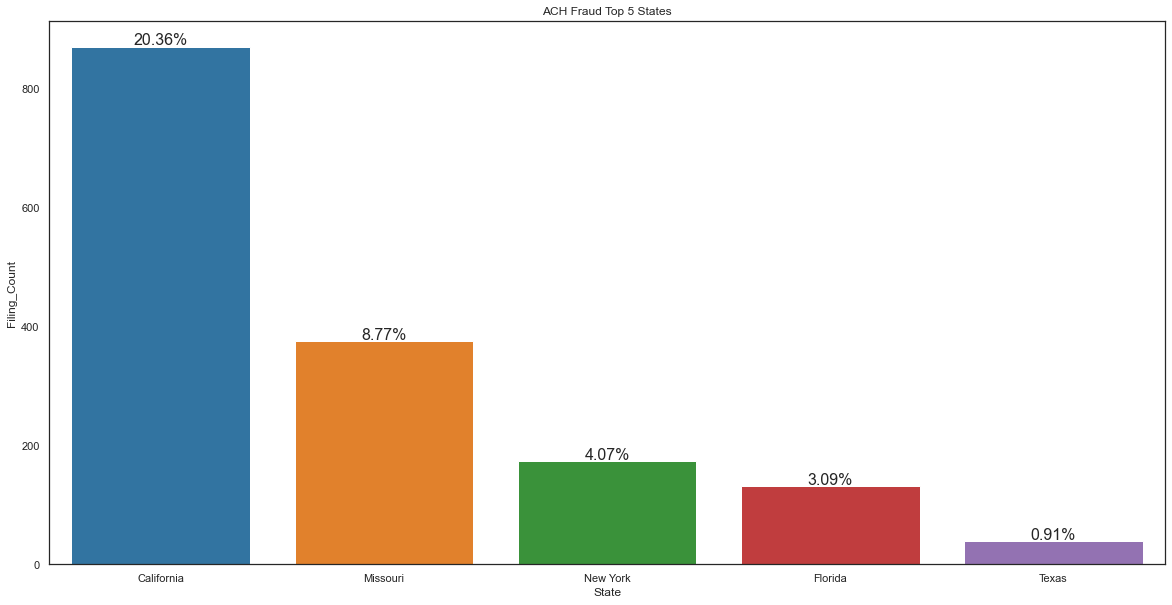

In [64]:
ACH = ACH_data.groupby('State')['Filing_Count'].sum().sort_values(ascending=False).head(5)
print(ACH)

# Plots
plt.figure(figsize=(20,10))
ax = sns.barplot(ACH.index, ACH.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("ACH Fraud Top 5 States")
plt.xlabel("State")
plt.ylabel("Filing_Count")
plt.show()

#### ACH FRAUD TOP 5 COUNTY

County
San Francisco County, CA    561
St. Louis city, MO          375
New York County, NY         108
Los Angeles County, CA       93
Seminole County, FL          75
Name: Filing_Count, dtype: int32


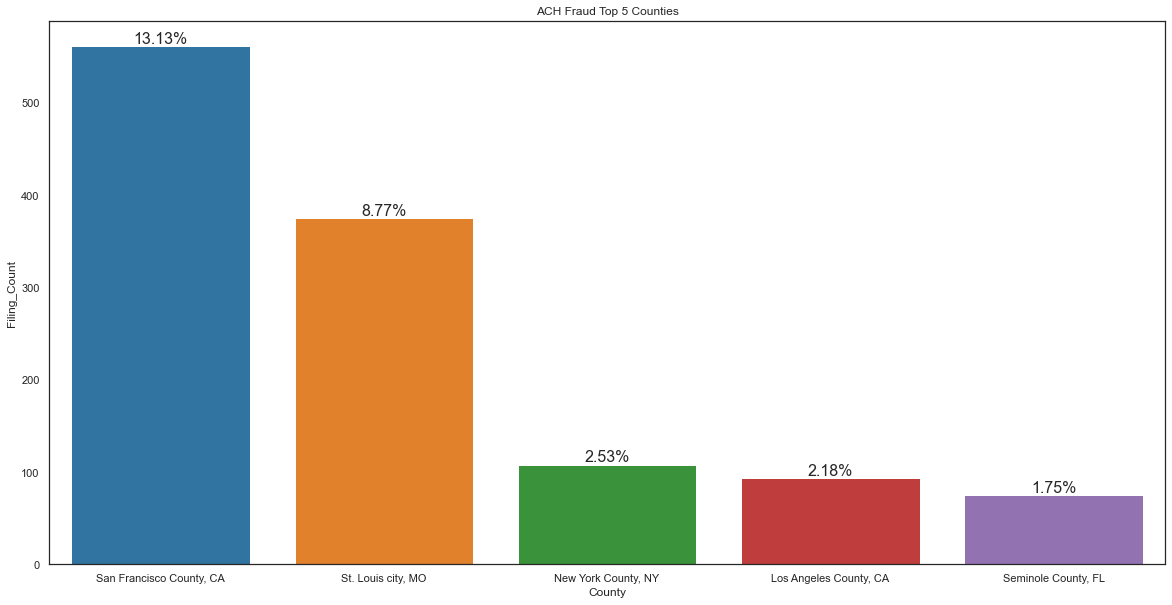

In [65]:
ACHC = ACH_data.groupby('County')['Filing_Count'].sum().sort_values(ascending=False).head(5)
print(ACHC)

# Plots
plt.figure(figsize=(20,10))
ax = sns.barplot(ACHC.index, ACHC.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("ACH Fraud Top 5 Counties")
plt.xlabel("County")
plt.ylabel("Filing_Count")
plt.show()

### Instrument used for ACH Fraud

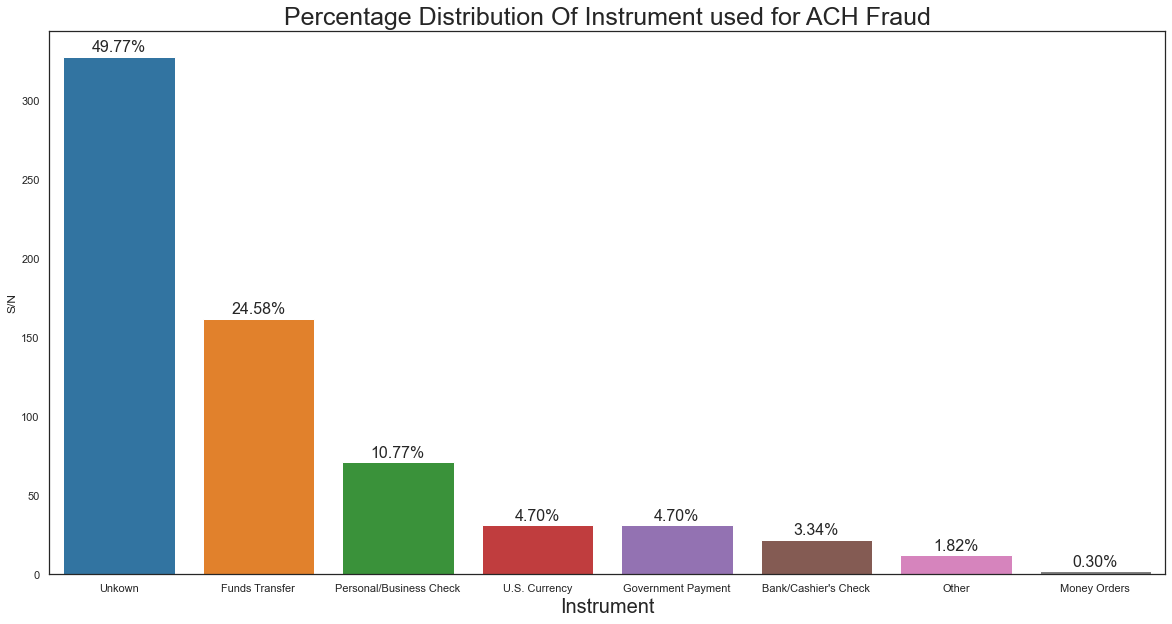

In [66]:
ACH_inst = ACH_data['Instrument'].value_counts()

total = len(ACH_data)
plt.figure(figsize=(20,10))

plt.rcParams['font.size'] = '16'

ax = sns.barplot(ACH_inst.index, ACH_inst.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Percentage Distribution Of Instrument used for ACH Fraud", fontsize=25)
plt.xlabel("Instrument", fontsize=20)
plt.ylabel("S/N")
plt.show()

### What Month of the Year the does crime on  ACH Fraud usually happen

In [67]:
ACH_table = ACH_data.stb.freq(['Year'],cum_cols = False)
ACH_table

Year  count    percent
0  2022    255  38.694992
1  2020    229  34.749621
2  2021    175  26.555387

In [68]:
FrqACH = ACH_data.stb.freq(['Month_Number'],cum_cols = False)

ACH_fraud_Month_Number = ACH_data.groupby('Month_Number').sum()

ACH_fraud_by_Month = pd.merge(ACH_fraud_Month_Number['Filing_Count'], FrqACH, on=['Month_Number'])
ACH_fraud_by_Month['Month'] = ['January','February','March','April','May','June','July','August', 'September','October','November','December']
ACH_fraud_by_Month

Month_Number  Filing_Count  count    percent      Month
0              1            33     19   2.883156    January
1              2           108     38   5.766313   February
2              3           132     61   9.256449      March
3              4           141     80  12.139605      April
4              5           144     41   6.221548        May
5              6           162     62   9.408194       June
6              7           291     57   8.649469       July
7              8           246     68  10.318665     August
8              9           282     72  10.925645  September
9             10           213     83  12.594841    October
10            11            33     26   3.945372   November
11            12            93     52   7.890744   December

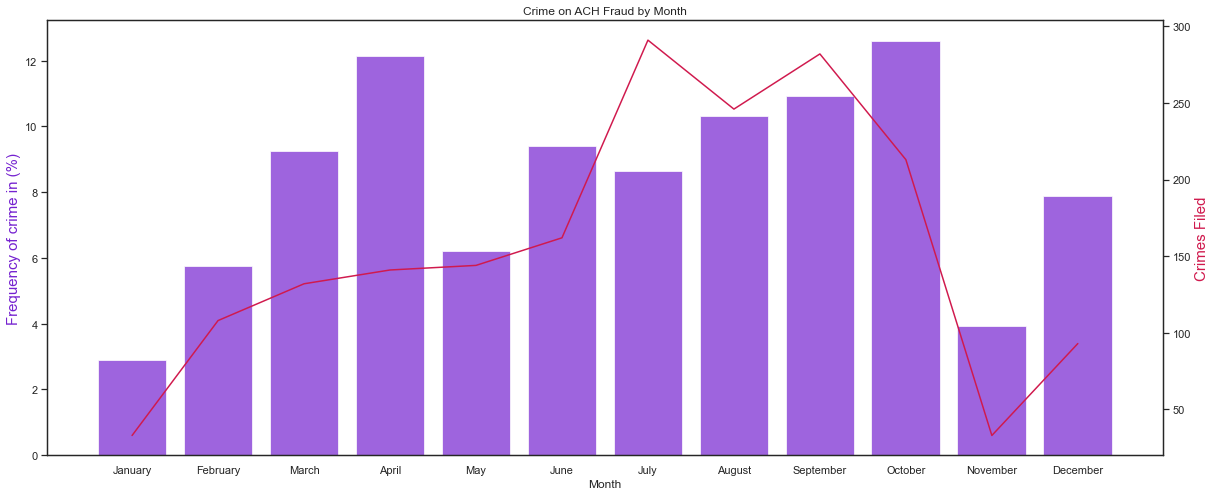

In [69]:
fig, ax1 = plt.subplots(figsize = (20,8))
ax2 = ax1.twinx()


ax1.bar(ACH_fraud_by_Month['Month'], ACH_fraud_by_Month['percent'], color = '#7522D0', alpha = 0.7)
    
ax1.set_xlabel('Month')
ax1.set_ylabel('Frequency of crime in (%)', color = '#7522D0', size = 15)
ax2.plot(ACH_fraud_by_Month.index , ACH_fraud_by_Month['Filing_Count'], color = '#D01A4E')

ax2.set_ylabel('Crimes Filed', size = 15, color = '#D01A4E')

plt.title('Crime on ACH Fraud by Month')


plt.show()

## IDENTITY THEFT

In [70]:
ID_data = df[df.Suspicious_Activity=='Identity Theft']
ID_data.head()

S/N       State                   County            Industry  \
6      7  California  Contra Costa County, CA  Securities/Futures   
7      8  California  Contra Costa County, CA  Securities/Futures   
8      9  California  Contra Costa County, CA  Securities/Futures   
131  154    Missouri       St. Louis city, MO  Securities/Futures   
132  155    Missouri       St. Louis city, MO  Securities/Futures   

    Suspicious_Activity Regulator      Product      Instrument  Filing_Count  \
6        Identity Theft       FRB  Credit Card  Funds Transfer             1   
7        Identity Theft       FRB  Credit Card          Unkown             1   
8        Identity Theft    Unkown  Credit Card          Unkown             1   
131      Identity Theft       FRB  Credit Card  Funds Transfer             2   
132      Identity Theft       FRB  Credit Card          Unkown             2   

            Financial_Crime_Type    Month  Month_Number  Year  
6    Other Suspicious Activities  January             1  2020  
7    Other Suspicious Activities  January             1  2020  
8    Other Suspicious Activities  January             1  2020  
131  Other Suspicious Activities  January             1  2020  
132  Other Suspicious Activities  January             1  2020

In [71]:
IDT = ID_data.copy()
IDT.drop(['S/N','Month_Number','Year','Filing_Count'], axis=1, inplace=True)


IDT.describe()

State              County            Industry  \
count          554                 554                 554   
unique          30                  69                   2   
top     California  St. Louis city, MO  Securities/Futures   
freq           152                 100                 510   

       Suspicious_Activity Regulator      Product Instrument  \
count                  554       554          554        554   
unique                   1         6            1          8   
top         Identity Theft       FRB  Credit Card     Unkown   
freq                   554       201          554        302   

               Financial_Crime_Type  Month  
count                           554    554  
unique                            1     12  
top     Other Suspicious Activities  March  
freq                            554     71

#### IDENTITY THEFT TOP 5 STATE

State
California    621
Missouri      534
New York       84
Florida        78
Virginia       33
Name: Filing_Count, dtype: int32


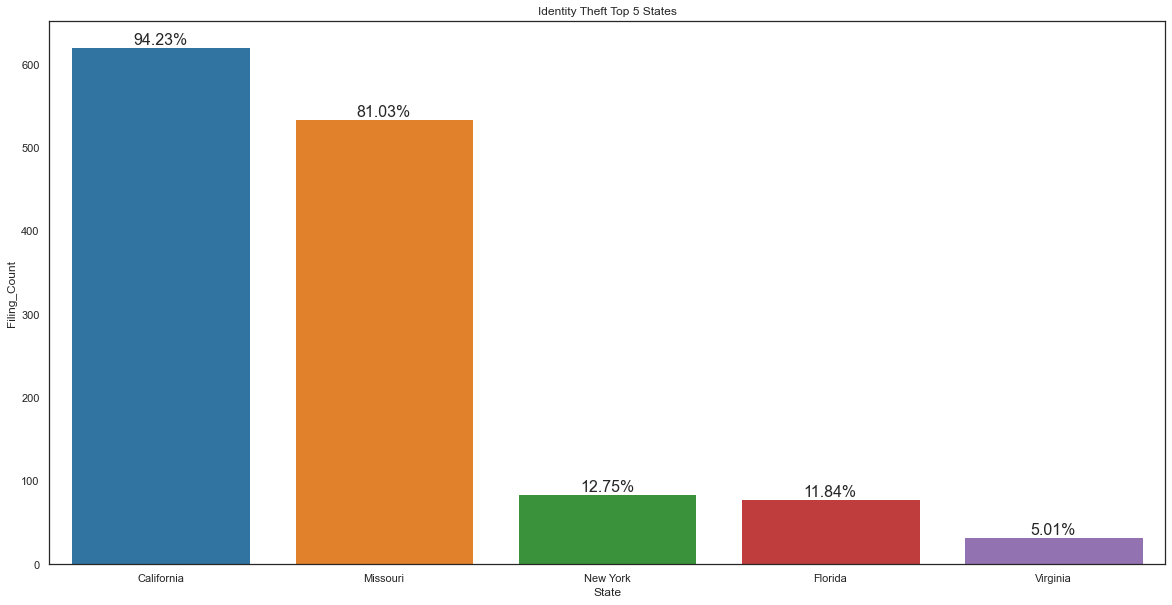

In [72]:
ID = ID_data.groupby('State')['Filing_Count'].sum().sort_values(ascending=False).head(5)
print(ID)

# Plots
plt.figure(figsize=(20,10))
ax = sns.barplot(ID.index, ID.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Identity Theft Top 5 States")
plt.xlabel("State")
plt.ylabel("Filing_Count")
plt.show()

#### IDENTITY THEFT TOP 5 COUNTY

County
St. Louis city, MO          525
San Francisco County, CA    423
New York County, NY          78
Seminole County, FL          39
Los Angeles County, CA       33
Name: Filing_Count, dtype: int32


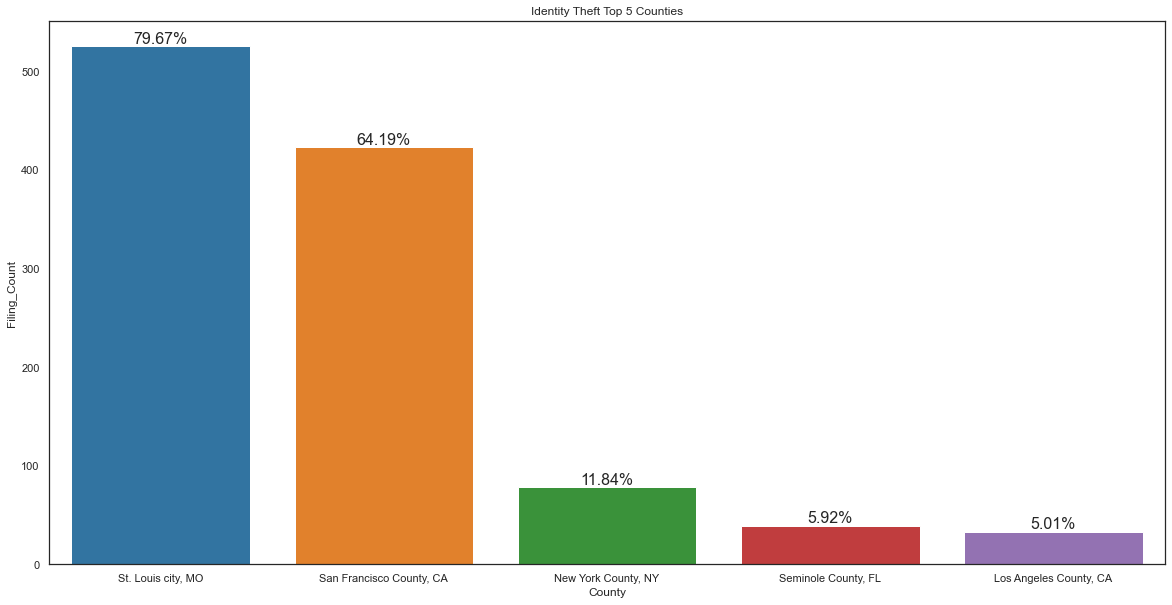

In [73]:
ID = ID_data.groupby('County')['Filing_Count'].sum().sort_values(ascending=False).head(5)
print(ID)

# Plots
plt.figure(figsize=(20,10))
ax = sns.barplot(ID.index, ID.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Identity Theft Top 5 Counties")
plt.xlabel("County")
plt.ylabel("Filing_Count")
plt.show()

### Instrument used for Identity Theft

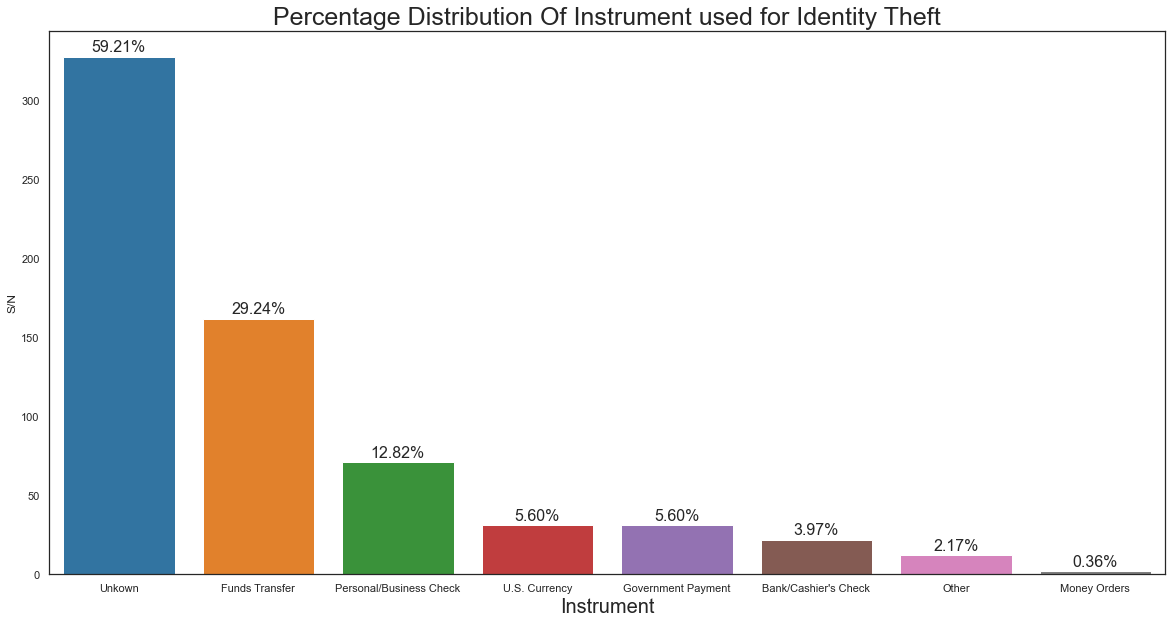

In [74]:
ID_inst = ID_data['Instrument'].value_counts()

total = len(ID_data)
plt.figure(figsize=(20,10))

plt.rcParams['font.size'] = '16'

ax = sns.barplot(ACH_inst.index, ACH_inst.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Percentage Distribution Of Instrument used for Identity Theft", fontsize=25)
plt.xlabel("Instrument", fontsize=20)
plt.ylabel("S/N")
plt.show()

### What Month of the Year the does crime on Identity Theft usually happen

In [75]:
ID_table = ID_data.stb.freq(['Year'],cum_cols = False)
ID_table

Year  count    percent
0  2020    247  44.584838
1  2022    185  33.393502
2  2021    122  22.021661

In [76]:
FrqID = ID_data.stb.freq(['Month_Number'],cum_cols = False)

IDT_Month_Number = ID_data.groupby('Month_Number').sum()

IDT_by_Month = pd.merge(IDT_Month_Number['Filing_Count'], FrqID, on=['Month_Number'])
IDT_by_Month['Month'] = ['January','February','March','April','May','June','July','August', 'September','October','November','December']
IDT_by_Month

Month_Number  Filing_Count  count    percent      Month
0              1            51     19   3.429603    January
1              2           138     64  11.552347   February
2              3           135     71  12.815884      March
3              4           126     69  12.454874      April
4              5           156     49   8.844765        May
5              6           111     40   7.220217       June
6              7           231     38   6.859206       July
7              8           177     52   9.386282     August
8              9           264     65  11.732852  September
9             10           141     44   7.942238    October
10            11            24     15   2.707581   November
11            12            51     28   5.054152   December

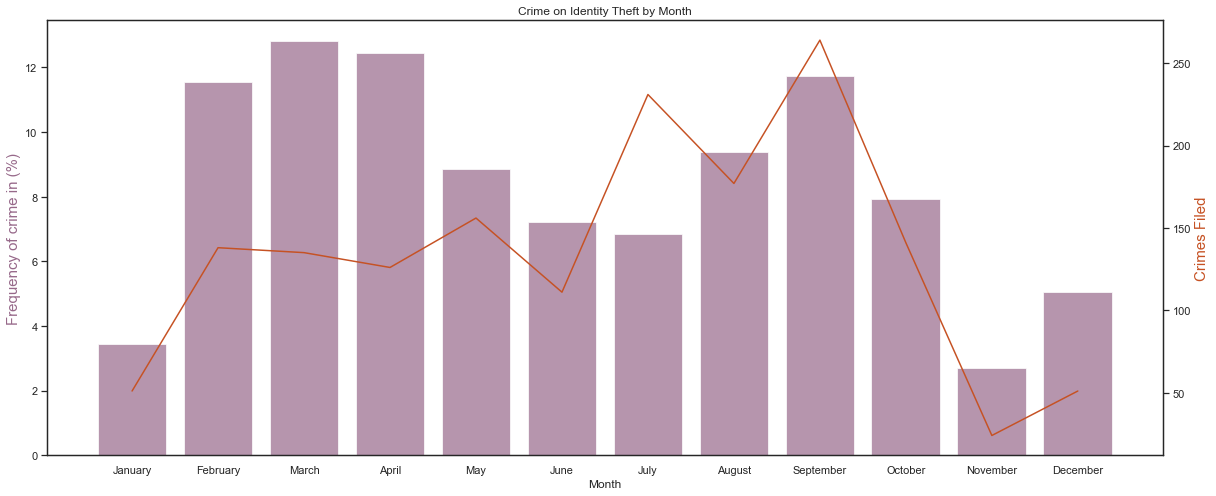

In [77]:
fig, ax1 = plt.subplots(figsize = (20,8))
ax2 = ax1.twinx()


ax1.bar(IDT_by_Month['Month'], IDT_by_Month['percent'], color = '#97698A', alpha = 0.7)
    
ax1.set_xlabel('Month')
ax1.set_ylabel('Frequency of crime in (%)', color = '#97698A', size = 15)
ax2.plot(IDT_by_Month.index , IDT_by_Month['Filing_Count'], color = '#C65224')

ax2.set_ylabel('Crimes Filed', size = 15, color = '#C65224')

plt.title('Crime on Identity Theft by Month')


plt.show()

## ELDER FINANCIAL EXPLOITATION (EFE)

- Elder financial exploitation (EFE) is the illegal or improper use of an older adult’s funds, property, or assets.
- According to the U.S. Department of Justice, elder abuse, which includes EFE among other forms of abuse, affects at least **10%** of older adults each year in the United States, with millions of older adults losing more than **$3 billion** to financial fraud annually as of 2019. Despite the fact that EFE is the most common form of elder abuse, the majority of incidents go unidentified and unreported as victims may choose not to come forward out of fear, embarrassment, or lack of resources.

https://www.fincen.gov/sites/default/files/advisory/2022-06-15/FinCEN%20Advisory%20Elder%20Financial%20Exploitation%20FINAL%20508.pdf

In [78]:
EFE_data = df[df.Suspicious_Activity=='Elder Financial Exploitation']
EFE_data.head()

S/N       State                   County            Industry  \
3     4  California  Contra Costa County, CA  Securities/Futures   
4     5  California  Contra Costa County, CA  Securities/Futures   
5     6  California  Contra Costa County, CA  Securities/Futures   
49   58  California    Stanislaus County, CA  Securities/Futures   
50   59  California    Stanislaus County, CA  Securities/Futures   

             Suspicious_Activity Regulator      Product            Instrument  \
3   Elder Financial Exploitation       FRB  Credit Card        Funds Transfer   
4   Elder Financial Exploitation       FRB  Credit Card                Unkown   
5   Elder Financial Exploitation    Unkown  Credit Card                Unkown   
49  Elder Financial Exploitation       SEC  Credit Card  Bank/Cashier's Check   
50  Elder Financial Exploitation       SEC  Credit Card        Funds Transfer   

    Filing_Count         Financial_Crime_Type    Month  Month_Number  Year  
3              1  Other Suspicious Activities  January             1  2020  
4              1  Other Suspicious Activities  January             1  2020  
5              1  Other Suspicious Activities  January             1  2020  
49             1  Other Suspicious Activities  January             1  2020  
50             1  Other Suspicious Activities  January             1  2020

In [79]:
EFE = EFE_data.copy()
EFE.drop(['S/N','Month_Number','Year','Filing_Count'], axis=1, inplace=True)


EFE.describe()

State              County            Industry  \
count          702                 702                 702   
unique          35                 108                   2   
top     California  St. Louis city, MO  Securities/Futures   
freq           121                 101                 693   

                 Suspicious_Activity Regulator      Product Instrument  \
count                            702       702          702        702   
unique                             1         5            1          7   
top     Elder Financial Exploitation       FRB  Credit Card     Unkown   
freq                             702       249          702        366   

               Financial_Crime_Type  Month  
count                           702    702  
unique                            1     12  
top     Other Suspicious Activities  April  
freq                            702     93

#### EFE TOP 5 STATE

State
Missouri      486
California    198
New York      123
Virginia       69
Texas          54
Name: Filing_Count, dtype: int32


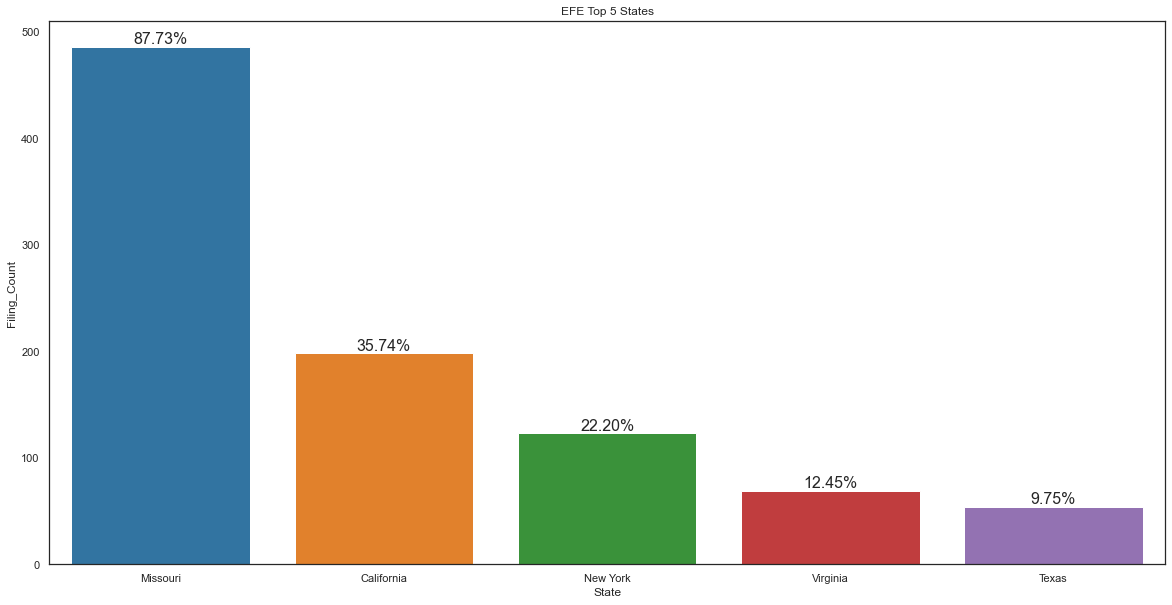

In [80]:
EFE_s = EFE_data.groupby('State')['Filing_Count'].sum().sort_values(ascending=False).head(5)
print(EFE_s)

# Plots
plt.figure(figsize=(20,10))
ax = sns.barplot(EFE_s.index, EFE_s.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("EFE Top 5 States")
plt.xlabel("State")
plt.ylabel("Filing_Count")
plt.show()

#### EFE TOP 5 COUNTY

County
St. Louis city, MO     486
New York County, NY     78
Orange County, CA       42
Maricopa County, AZ     33
Harris County, TX       33
Name: Filing_Count, dtype: int32


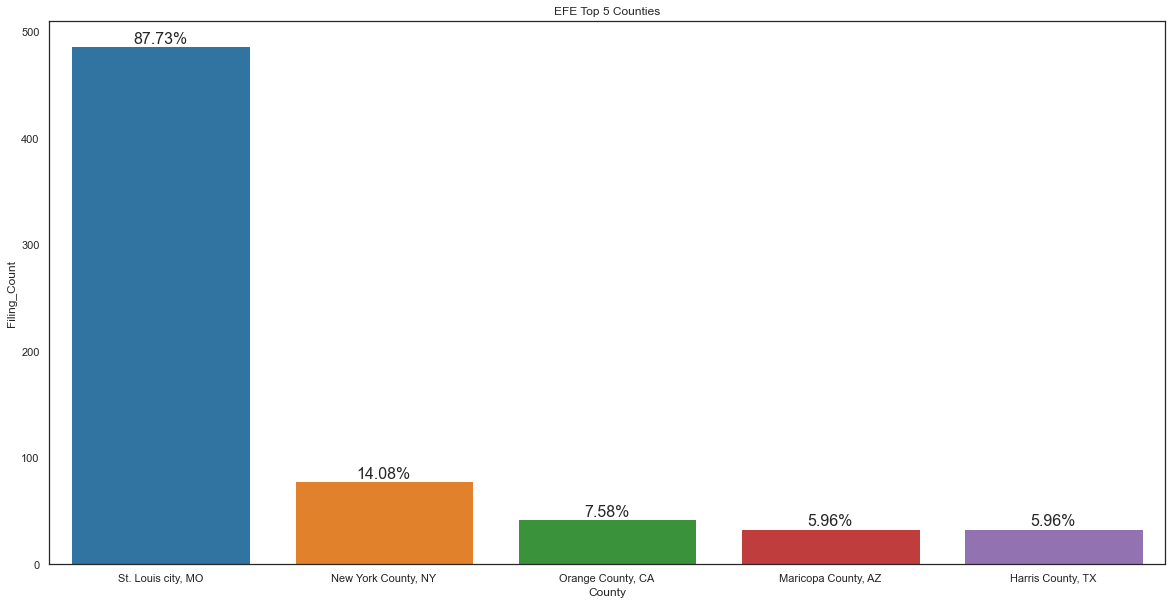

In [81]:
EFE_c = EFE_data.groupby('County')['Filing_Count'].sum().sort_values(ascending=False).head(5)
print(EFE_c)

# Plots
plt.figure(figsize=(20,10))
ax = sns.barplot(EFE_c.index, EFE_c.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("EFE Top 5 Counties")
plt.xlabel("County")
plt.ylabel("Filing_Count")
plt.show()

### Instrument used for EFE

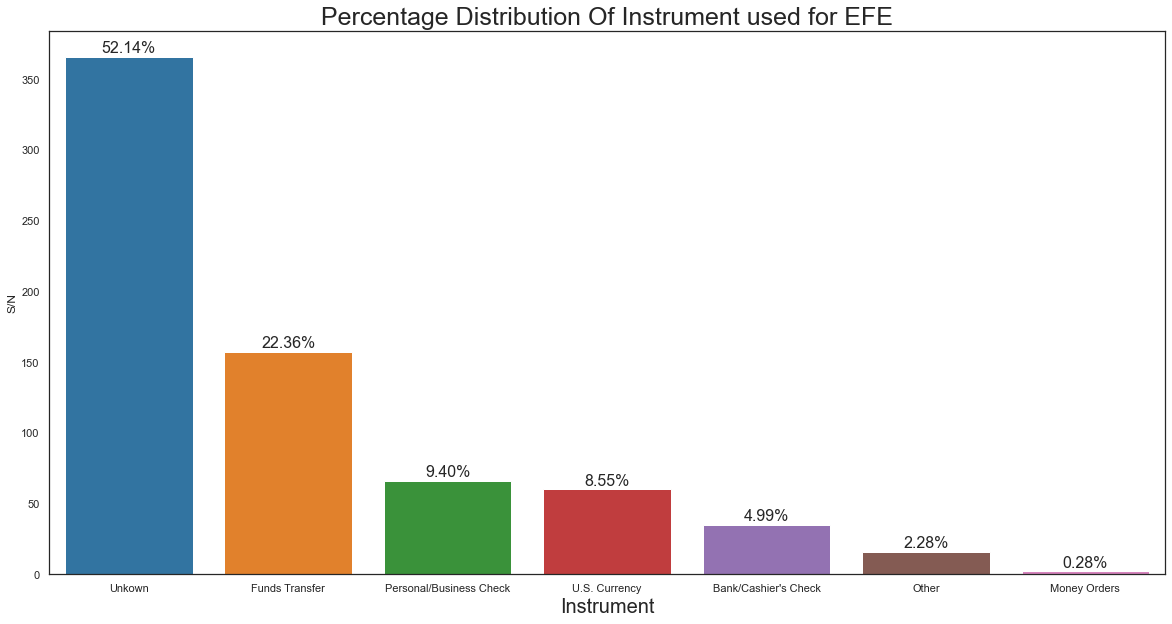

In [82]:
EFE_inst = EFE_data['Instrument'].value_counts()

total = len(EFE_data)
plt.figure(figsize=(20,10))

plt.rcParams['font.size'] = '16'

ax = sns.barplot(EFE_inst.index, EFE_inst.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            f"{height/total*100 :1.2f}%",
            ha="center")
    
plt.title("Percentage Distribution Of Instrument used for EFE", fontsize=25)
plt.xlabel("Instrument", fontsize=20)
plt.ylabel("S/N")
plt.show()

### What Month of the Year the does crime on EFE usually happen

In [83]:
EFE_table = EFE_data.stb.freq(['Year'],cum_cols = False)
EFE_table

Year  count    percent
0  2020    357  50.854701
1  2022    175  24.928775
2  2021    170  24.216524

In [84]:
FrqEFE = EFE_data.stb.freq(['Month_Number'],cum_cols = False)

EFE_Month_Number = EFE_data.groupby('Month_Number').sum()

EFE_by_Month = pd.merge(EFE_Month_Number['Filing_Count'], FrqEFE, on=['Month_Number'])
EFE_by_Month['Month'] = ['January','February','March','April','May','June','July','August', 'September','October','November','December']
EFE_by_Month

Month_Number  Filing_Count  count    percent      Month
0              1            69     40   5.698006    January
1              2           174     83  11.823362   February
2              3            75     42   5.982906      March
3              4           147     93  13.247863      April
4              5           126     51   7.264957        May
5              6            84     57   8.119658       June
6              7           114     46   6.552707       July
7              8           129     74  10.541311     August
8              9           192     72  10.256410  September
9             10           183     78  11.111111    October
10            11            66     38   5.413105   November
11            12            48     28   3.988604   December

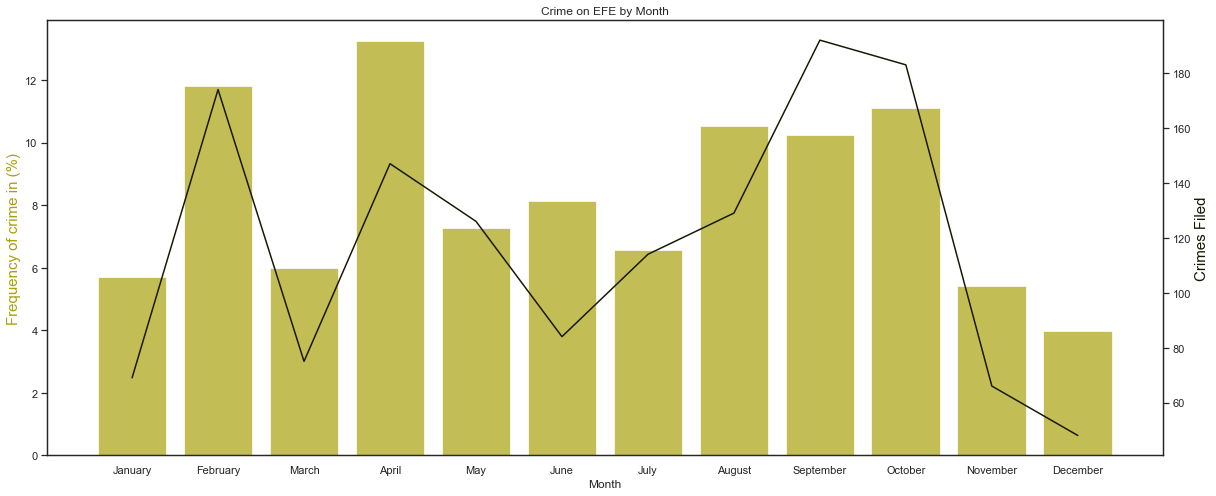

In [85]:
fig, ax1 = plt.subplots(figsize = (20,8))
ax2 = ax1.twinx()


ax1.bar(EFE_by_Month['Month'], EFE_by_Month['percent'], color = '#A8A10C', alpha = 0.7)
    
ax1.set_xlabel('Month')
ax1.set_ylabel('Frequency of crime in (%)', color = '#A8A10C', size = 15)
ax2.plot(EFE_by_Month.index , EFE_by_Month['Filing_Count'], color = '#181702')

ax2.set_ylabel('Crimes Filed', size = 15, color = '#181702')

plt.title('Crime on EFE by Month')


plt.show()